In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

## RH is Relative Humidity ( How much water vapour the atmosphere holds in  percentage (%) )
## T is the temperature of the atmosphere
## Gas is the type of pollution Gas present in the atmosphere
## Value is the measurement of gas in the atmosphere in micrograms per cubic meter (µg/m3)

In [389]:
# Load the dataset for train
train_dataset = pd.read_csv("train.csv")
train_dataset.head(10)

Date          T         RH Gas        Value
0  10/3/2004  12.020833  54.883334  CO  1316.500000
1  11/3/2004   9.833333  64.069791  CO  1244.062500
2  12/3/2004  11.292708  51.107292  CO  1281.562500
3  13/3/2004  12.866319  51.530903  CO  1330.555556
4  14/3/2004  16.016667  48.843750  CO  1360.927083
5  15/3/2004  17.370833  50.320833  CO  1452.010417
6  16/3/2004  18.627778  44.825000  CO  1339.621528
7  17/3/2004  18.772917  41.165625  CO  1362.708333
8  18/3/2004  17.760764  44.084722  CO  1352.569444
9  19/3/2004  14.194792  57.904167  CO  1304.208333

In [390]:
train_dataset.tail(10)

Date          T         RH Gas        Value
1302  22/1/2005   9.937153  55.851389  O3  1468.784722
1303  23/1/2005   5.819792  53.878125  O3  1027.562500
1304  24/1/2005   7.668750  47.883333  O3   794.770833
1305  25/1/2005   4.509028  50.969097  O3   527.177083
1306  26/1/2005   4.213542  49.477083  O3   567.697917
1307  27/1/2005   5.267708  39.614930  O3   691.475694
1308  28/1/2005 -55.515972 -24.010417  O3   429.375000
1309  29/1/2005 -14.272917  28.563542  O3   418.072917
1310  30/1/2005   4.848611  37.832986  O3   474.392361
1311  31/1/2005   7.273958  31.809375  O3  1184.166667

In [391]:
# Checking for data types
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1312 non-null   object 
 1   T       1312 non-null   float64
 2   RH      1312 non-null   float64
 3   Gas     1312 non-null   object 
 4   Value   1312 non-null   float64
dtypes: float64(3), object(2)
memory usage: 51.4+ KB


In [392]:
train_dataset.shape

(1312, 5)

In [393]:
#  Check the number of each gas
train_gas = train_dataset['Gas'].value_counts().reset_index()
train_gas.columns = ['Gas', 'count']
print(train_gas)

    Gas  count
0    CO    328
1    O3    328
2   NOx    328
3  NMHC    328


In [394]:
#  Check the number of each Date
train_date = train_dataset['Date'].value_counts().reset_index()
train_date.columns = ['Date', 'count']
print(train_date)

           Date  count
0    13/12/2004      4
1     27/3/2004      4
2     16/3/2004      4
3    19/12/2004      4
4    24/11/2004      4
..          ...    ...
323   23/7/2004      4
324    4/4/2004      4
325   17/8/2004      4
326    9/1/2005      4
327  10/12/2004      4

[328 rows x 2 columns]


In [395]:
# Set Date column of training data as index
train_dataset.index = pd.to_datetime(train_dataset.Date, format = '%d/%m/%Y')
train_dataset.drop('Date',axis = 1, inplace = True)
train_dataset.head(10)

T         RH Gas        Value
Date                                             
2004-03-10  12.020833  54.883334  CO  1316.500000
2004-03-11   9.833333  64.069791  CO  1244.062500
2004-03-12  11.292708  51.107292  CO  1281.562500
2004-03-13  12.866319  51.530903  CO  1330.555556
2004-03-14  16.016667  48.843750  CO  1360.927083
2004-03-15  17.370833  50.320833  CO  1452.010417
2004-03-16  18.627778  44.825000  CO  1339.621528
2004-03-17  18.772917  41.165625  CO  1362.708333
2004-03-18  17.760764  44.084722  CO  1352.569444
2004-03-19  14.194792  57.904167  CO  1304.208333

In [396]:
train_dataset.shape

(1312, 4)

In [397]:
# After sorting the index, we see that there are 4 dates for every gas type
sorted_train = train_dataset.sort_index()
sorted_train.head(10)

T         RH   Gas        Value
Date                                               
2004-03-10  12.020833  54.883334    CO  1316.500000
2004-03-10  12.020833  54.883334   NOx  1167.250000
2004-03-10  12.020833  54.883334  NMHC   912.250000
2004-03-10  12.020833  54.883334    O3  1096.041667
2004-03-11   9.833333  64.069791    CO  1244.062500
2004-03-11   9.833333  64.069791    O3   885.031250
2004-03-11   9.833333  64.069791   NOx  1277.187500
2004-03-11   9.833333  64.069791  NMHC   851.802083
2004-03-12  11.292708  51.107292    CO  1281.562500
2004-03-12  11.292708  51.107292  NMHC  1008.229167

In [398]:
# Pivot the table to get the T, RH and Value of each gas 
train_pivot = train_dataset.pivot(columns="Gas")
train_pivot.head(10)

T                                          RH             \
Gas                CO       NMHC        NOx         O3         CO       NMHC   
Date                                                                           
2004-03-10  12.020833  12.020833  12.020833  12.020833  54.883334  54.883334   
2004-03-11   9.833333   9.833333   9.833333   9.833333  64.069791  64.069791   
2004-03-12  11.292708  11.292708  11.292708  11.292708  51.107292  51.107292   
2004-03-13  12.866319  12.866319  12.866319  12.866319  51.530903  51.530903   
2004-03-14  16.016667  16.016667  16.016667  16.016667  48.843750  48.843750   
2004-03-15  17.370833  17.370833  17.370833  17.370833  50.320833  50.320833   
2004-03-16  18.627778  18.627778  18.627778  18.627778  44.825000  44.825000   
2004-03-17  18.772917  18.772917  18.772917  18.772917  41.165625  41.165625   
2004-03-18  17.760764  17.760764  17.760764  17.760764  44.084722  44.084722   
2004-03-19  14.194792  14.194792  14.194792  14.194792  57.904167  57.904167   

                                        Value                            \
Gas               NOx         O3           CO         NMHC          NOx   
Date                                                                      
2004-03-10  54.883334  54.883334  1316.500000   912.250000  1167.250000   
2004-03-11  64.069791  64.069791  1244.062500   851.802083  1277.187500   
2004-03-12  51.107292  51.107292  1281.562500  1008.229167  1101.718750   
2004-03-13  51.530903  51.530903  1330.555556   992.822917   993.159722   
2004-03-14  48.843750  48.843750  1360.927083   943.854167  1001.104167   
2004-03-15  50.320833  50.320833  1452.010417  1138.843750   845.562500   
2004-03-16  44.825000  44.825000  1339.621528  1061.763889   939.149306   
2004-03-17  41.165625  41.165625  1362.708333  1098.937500   930.427083   
2004-03-18  44.084722  44.084722  1352.569444  1072.517361   901.111111   
2004-03-19  57.904167  57.904167  1304.208333  1057.916667   913.177083   

                         
Gas                  O3  
Date                     
2004-03-10  1096.041667  
2004-03-11   885.031250  
2004-03-12  1084.218750  
2004-03-13  1245.781250  
2004-03-14  1234.177083  
2004-03-15  1439.041667  
2004-03-16  1322.475694  
2004-03-17  1405.677083  
2004-03-18  1300.805556  
2004-03-19  1095.708333

# Analysis on CO Gas

In [399]:
df_CO = pd.DataFrame(train_pivot["T"]["CO"])
df_CO = pd.concat([df_CO, train_pivot["RH"]["CO"]], axis=1)
df_CO = pd.concat([df_CO, train_pivot["Value"]["CO"]], axis=1)
df_CO.columns = ['T','RH','CO']
df_CO.head()

T         RH           CO
Date                                         
2004-03-10  12.020833  54.883334  1316.500000
2004-03-11   9.833333  64.069791  1244.062500
2004-03-12  11.292708  51.107292  1281.562500
2004-03-13  12.866319  51.530903  1330.555556
2004-03-14  16.016667  48.843750  1360.927083

In [400]:
# Load the dataset for test
test_dataset = pd.read_csv("test.csv")
test_dataset.head(10)

id       Date           T          RH Gas
0   0   1/2/2005    6.616667   51.734375  CO
1   1   2/2/2005    7.613194   43.930903  CO
2   2   3/2/2005    7.252083   50.966667  CO
3   3   4/2/2005    7.473611   50.166319  CO
4   4   5/2/2005    5.571875   46.604167  CO
5   5   6/2/2005    5.310417   39.594792  CO
6   6   7/2/2005    7.307986   35.396875  CO
7   7   8/2/2005  -52.136458  -32.741667  CO
8   8   9/2/2005 -200.000000 -200.000000  CO
9   9  10/2/2005 -200.000000 -200.000000  CO

In [401]:
test_dataset.tail(10)

id       Date          T         RH Gas
242  242  26/3/2005  18.951042  57.904514  O3
243  243  27/3/2005  15.609375  72.442709  O3
244  244  28/3/2005  17.933333  60.757291  O3
245  245  29/3/2005  15.911806  62.536111  O3
246  246  30/3/2005  17.420833  54.032292  O3
247  247  31/3/2005  17.554167  50.092708  O3
248  248   1/4/2005  15.919792  35.959722  O3
249  249   2/4/2005  15.489583  32.213542  O3
250  250   3/4/2005  18.381250  33.686458  O3
251  251   4/4/2005  16.966667  42.791667  O3

In [402]:
# Set Date column of Test data as index
test_dataset.index = pd.to_datetime(test_dataset.Date, format = '%d/%m/%Y')
test_dataset.drop('Date',axis = 1, inplace = True)
test_dataset.head(10)

id           T          RH Gas
Date                                      
2005-02-01   0    6.616667   51.734375  CO
2005-02-02   1    7.613194   43.930903  CO
2005-02-03   2    7.252083   50.966667  CO
2005-02-04   3    7.473611   50.166319  CO
2005-02-05   4    5.571875   46.604167  CO
2005-02-06   5    5.310417   39.594792  CO
2005-02-07   6    7.307986   35.396875  CO
2005-02-08   7  -52.136458  -32.741667  CO
2005-02-09   8 -200.000000 -200.000000  CO
2005-02-10   9 -200.000000 -200.000000  CO

In [403]:
# Get CO gas test data
testdf_CO = test_dataset.loc[test_dataset['Gas'] == 'CO']
testdf_CO.head()

id         T         RH Gas
Date                                   
2005-02-01   0  6.616667  51.734375  CO
2005-02-02   1  7.613194  43.930903  CO
2005-02-03   2  7.252083  50.966667  CO
2005-02-04   3  7.473611  50.166319  CO
2005-02-05   4  5.571875  46.604167  CO

In [404]:
#  Check the number of each gas
test_gas = test_dataset['Gas'].value_counts().reset_index()
test_gas.columns = ['Gas', 'count']
print(test_gas)

    Gas  count
0   NOx     63
1    CO     63
2    O3     63
3  NMHC     63


In [405]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

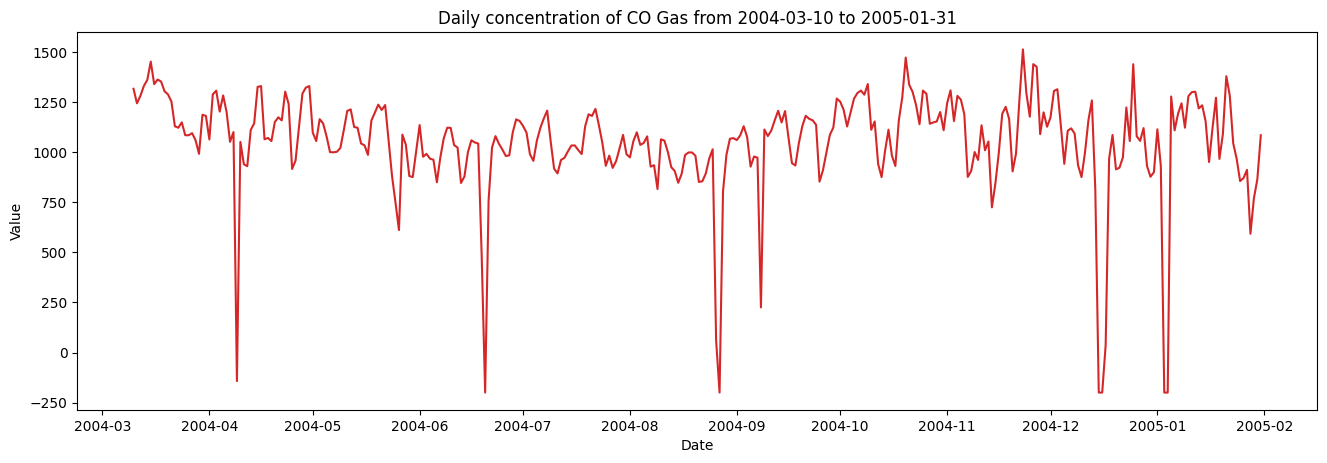

In [406]:
plot_df(df=df_CO, x=df_CO.index, y=df_CO['CO'], title='Daily concentration of CO Gas from 2004-03-10 to 2005-01-31')    

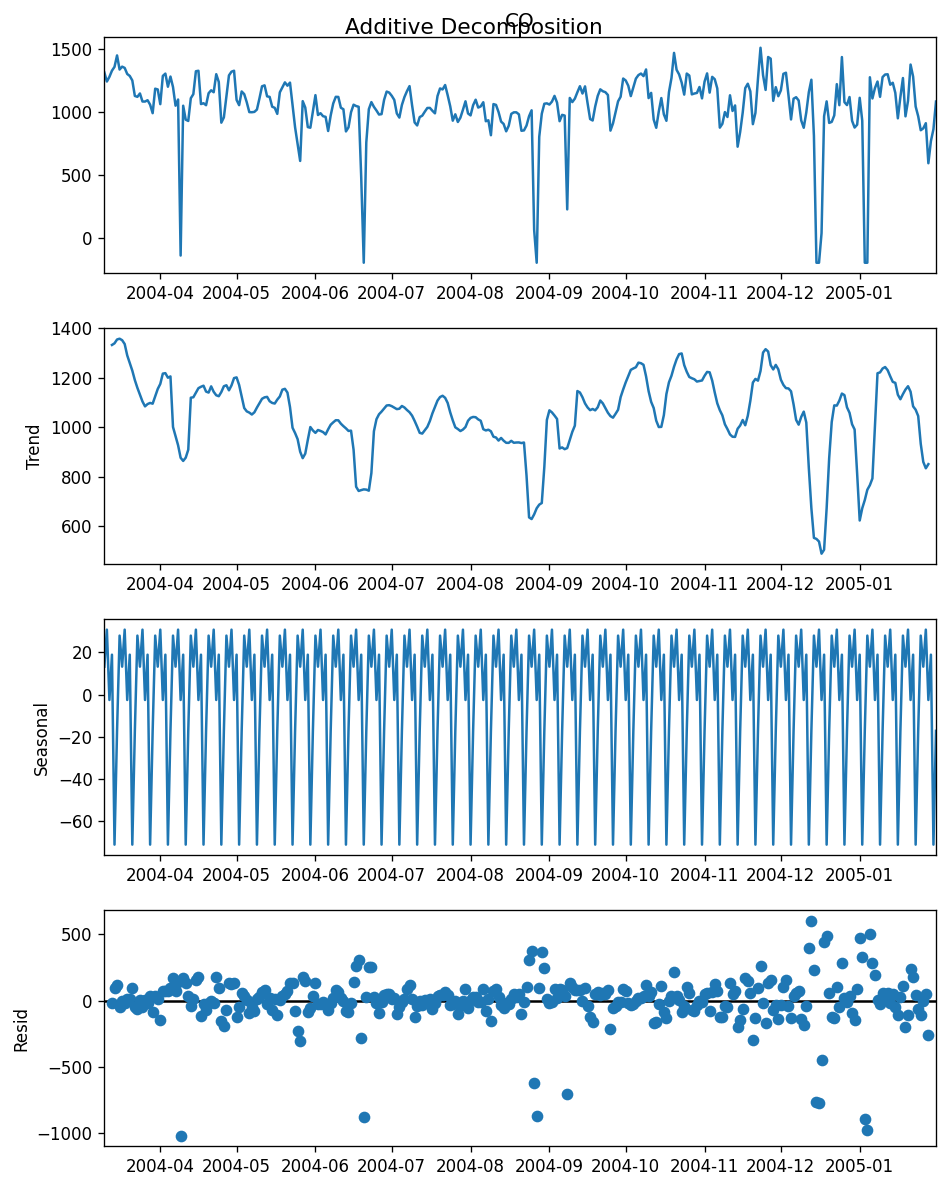

In [407]:
#Time Series Decomposition

# Additive Decomposition
result_add_CO = seasonal_decompose(df_CO['CO'], model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (8,10)})
result_add_CO.plot().suptitle('Additive Decomposition', fontsize=13)
plt.show()

## CO gas does not seem to have any obvious trend, but has a clear seasonality which repeats roughly 4 times a month, or once every week.

In [408]:
# Time series appear to be stationary
adftest = adfuller(df_CO['CO'])
print('number of observation:', adftest[3], '\np-value:', adftest[1])

number of observation: 326 
p-value: 2.6870035748129694e-16


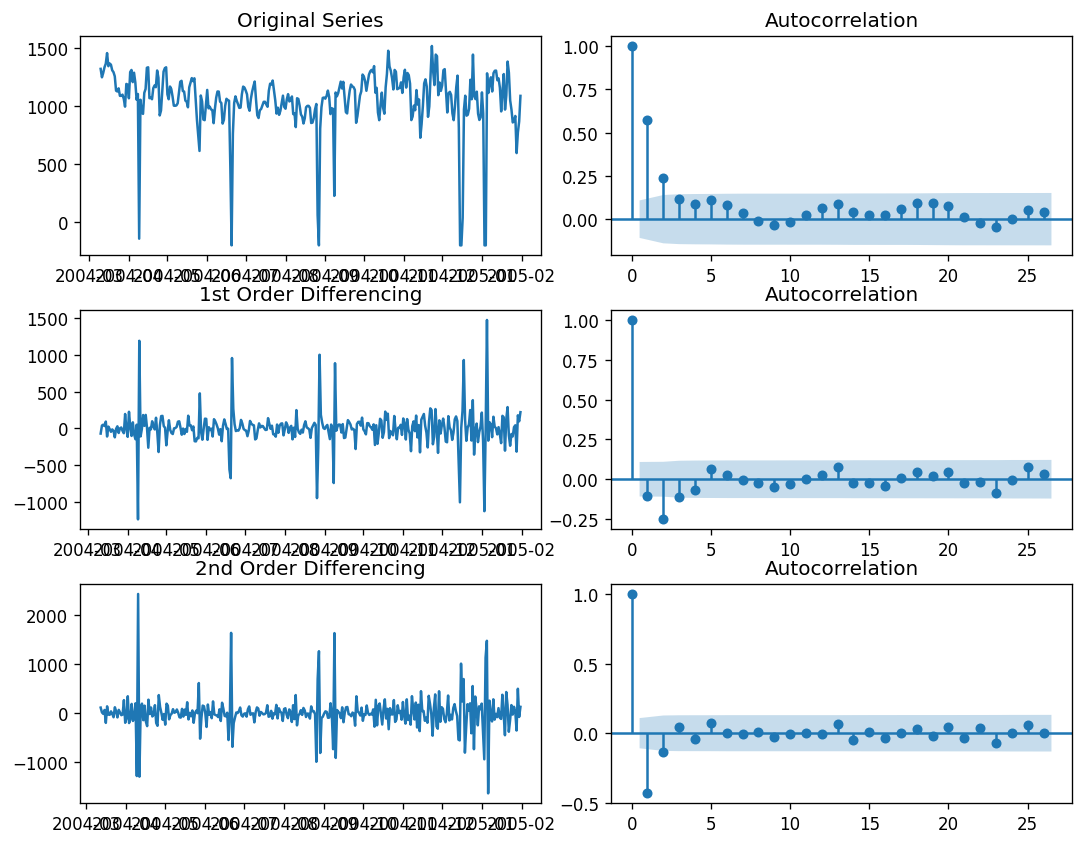

In [409]:
# ACF plots of CO gas
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(df_CO['CO']); axes[0, 0].set_title('Original Series')
plot_acf(df_CO['CO'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_CO['CO'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_CO['CO'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_CO['CO'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_CO['CO'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## Here I decided to go with a difference of one and q=2 as the lag 2 of the ACF plot is significant.

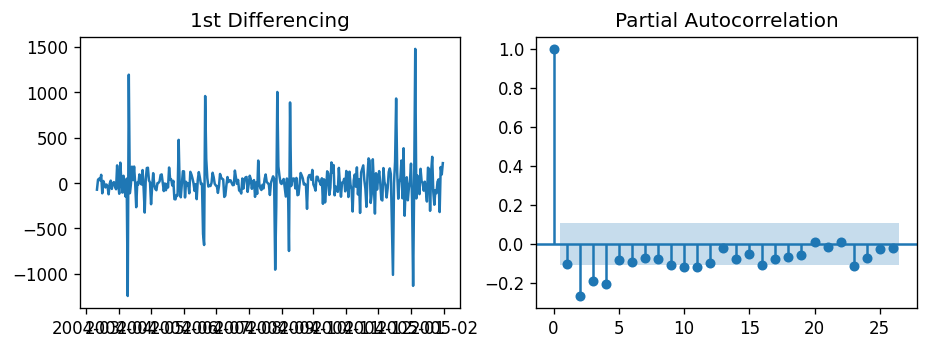

In [410]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_CO['CO'].diff()); axes[0].set_title('1st Differencing')
#axes[1].set(ylim=(0,5))
plot_pacf(df_CO['CO'].diff().dropna(), ax=axes[1])

plt.show()

## Looking at the PACF of the first differenced series, it seems that lag 2, 3 and 4 are all significant, but I'll go with q = 0 for now.

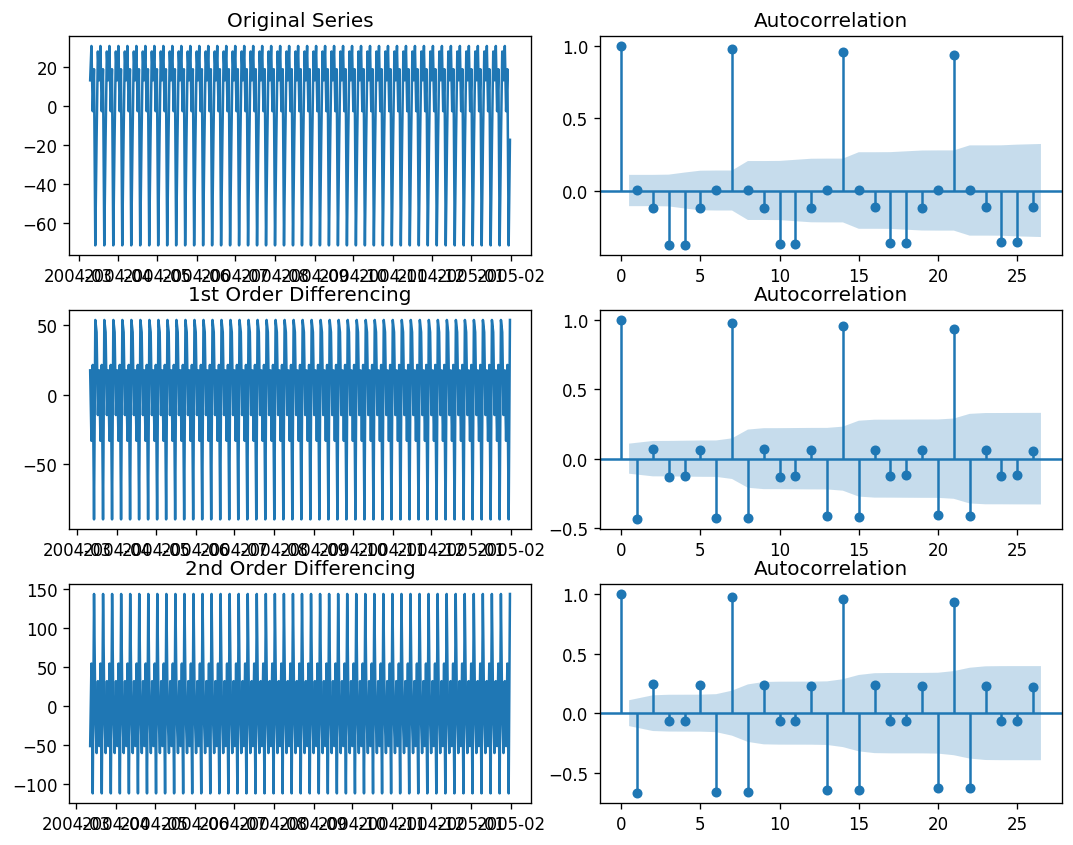

In [411]:
# ACF plots of seasonality of CO gas
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(result_add_CO.seasonal); axes[0, 0].set_title('Original Series')
plot_acf(result_add_CO.seasonal, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(result_add_CO.seasonal.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(result_add_CO.seasonal.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(result_add_CO.seasonal.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(result_add_CO.seasonal.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## For the 1st differenced series of the seasonality, lag 1 is significant, so I'll go with Q = 1 for the seasonal order.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


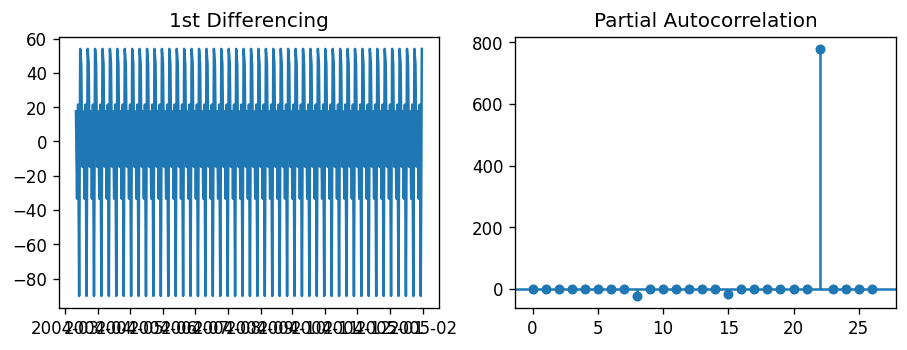

In [412]:
# PACF plot of 1st differenced series of seasonality
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(result_add_CO.seasonal.diff()); axes[0].set_title('1st Differencing')
#axes[1].set(ylim=(0,5))
plot_pacf(result_add_CO.seasonal.diff().dropna(), ax=axes[1])

plt.show()

## The PACF of the first differenced series of seasonality shows that the only significant lag is lag 22. I'll go with P = 0 for the seasonal order.

In [413]:
# Split train and test data into about 75% train 25% test
train_CO = df_CO['CO'].loc['2004-03-10':'2004-10-10']
test_CO = df_CO['CO'].loc['2004-10-11':'2005-01-31']
exog_train_CO = df_CO[['T','RH']].loc['2004-03-10':'2004-10-10']
exog_forecast_CO = df_CO[['T','RH']].loc['2004-10-11':'2005-01-31']

## Here I split my data into roughly 75% train and 25% test. I also included 'T' temperature and 'RH' relative humidity as exogenous variables in the model because they help to improve accuracy.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


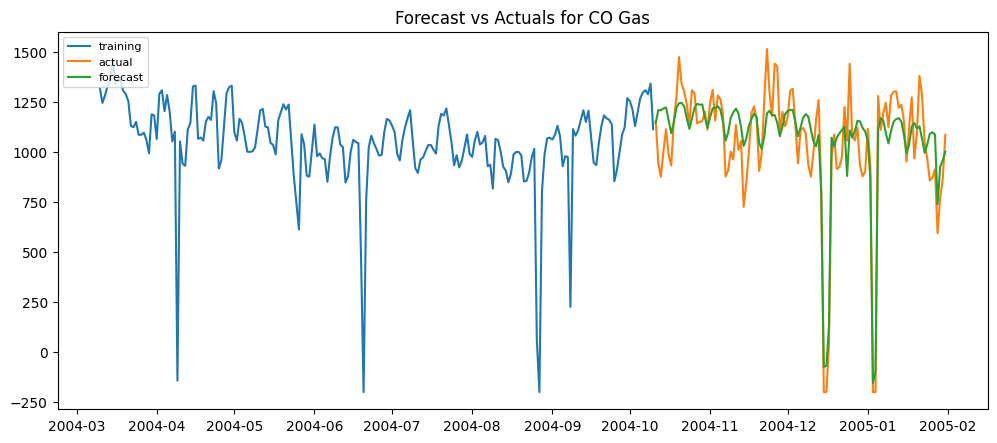

In [414]:
# Build Model
model_CO = SARIMAX(train_CO, order=(2,1,0),
                      seasonal_order=(0,1,1,7), exog=exog_train_CO) 
fitted_CO = model_CO.fit()  

pred_CO = fitted_CO.get_prediction(start=pd.to_datetime('2004-03-10'),
                                  end=pd.to_datetime('2005-01-31'), exog=exog_forecast_CO).predicted_mean
fc_series_CO = pd.Series(pred_CO.loc['2004-10-11':'2005-01-31'], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_CO, label='training')
plt.plot(test_CO, label='actual')
plt.plot(fc_series_CO, label='forecast')
plt.title('Forecast vs Actuals for CO Gas')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Here I set the parameter m (periodicity) = 7 as the seasonal period repeats every 7 days. I passed in exog_forecast into get_prediction which are the T and RH values for the testing period that I defined to help the model accuracy. Finally I plot the values to see how my model's predicted values compare against the actual ones.

In [415]:
fitted_CO.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  CO   No. Observations:                  215
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1185.402
Date:                             Fri, 13 Aug 2021   AIC                           2382.803
Time:                                     20:22:52   BIC                           2402.800
Sample:                                 03-10-2004   HQIC                          2390.890
                                      - 10-10-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              3.5053      0.697      5.027      0.000       2.139       4.872
RH             1.9133      0.614      3.116      0.002       0.710       3.117
ar.L1         -0.0552      0.081     -0.683      0.495      -0.214       0.103
ar.L2         -0.1701      0.060     -2.838      0.005      -0.288      -0.053
ma.S.L7       -0.9986      2.316     -0.431      0.666      -5.538       3.541
sigma2      4919.0515   1.14e+04      0.433      0.665   -1.74e+04    2.72e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                11.94
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## The p-value for T and RH are very small (less than 0.05) and the coefficient of T and RH are large, which shows that they are significant to the model.

In [416]:
# calculate MAPE for both training and testing data
MAPE_training_CO = mean_absolute_percentage_error(train_CO, pred_CO.loc['2004-03-10':'2004-10-10'])
MAPE_testing_CO = mean_absolute_percentage_error(test_CO, pred_CO.loc['2004-10-11':'2005-01-31'])
print(f'Training Error is: {MAPE_training_CO*100:.2f}%')
print(f'Testing Error is: {MAPE_testing_CO*100:.2f}%')

Training Error is: 6.81%
Testing Error is: 14.84%


In [417]:
# Fit final model on all of the CO values in train.csv
sarimax_model_CO = SARIMAX(df_CO['CO'], order=(2,1,0),
                      seasonal_order=(0,1,1,7), exog=df_CO[['T','RH']]).fit()
sarimax_model_CO.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  CO   No. Observations:                  328
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1906.474
Date:                             Fri, 13 Aug 2021   AIC                           3824.947
Time:                                     20:22:53   BIC                           3847.557
Sample:                                 03-10-2004   HQIC                          3833.976
                                      - 01-31-2005                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.9825      0.669      1.469      0.142      -0.328       2.293
RH             4.3493      0.566      7.682      0.000       3.240       5.459
ar.L1         -0.0476      0.057     -0.829      0.407      -0.160       0.065
ar.L2         -0.1793      0.045     -4.002      0.000      -0.267      -0.091
ma.S.L7       -0.9982      0.495     -2.018      0.044      -1.968      -0.029
sigma2      8064.3744   3813.275      2.115      0.034     590.493    1.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                10.45
Prob(Q):                              0.59   Prob(JB):                         0.01
Heteroskedasticity (H):               1.91   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

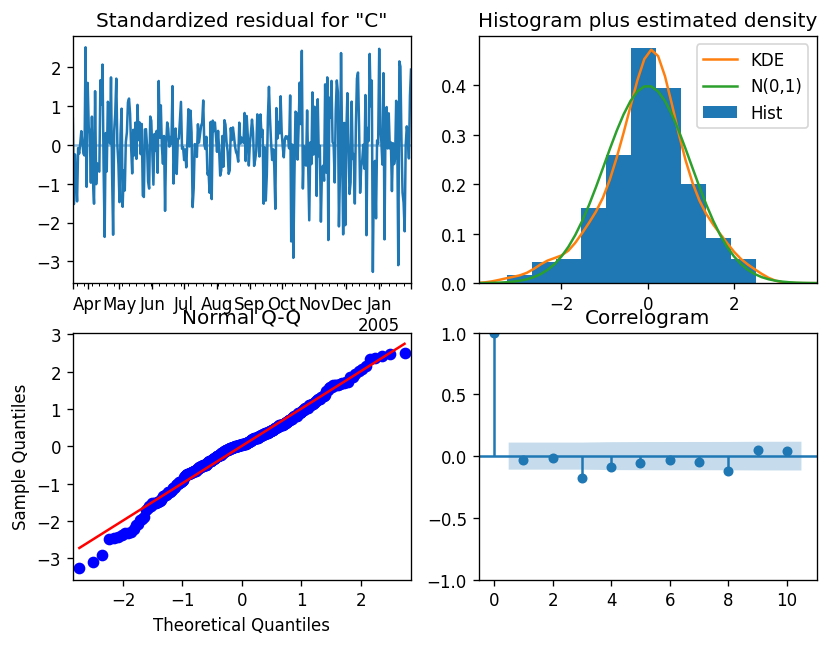

In [418]:
sarimax_model_CO.plot_diagnostics(figsize=(8, 6))
plt.show()

In [419]:
exog_forecast_CO_final = testdf_CO[['T','RH']]
exog_forecast_CO_final

T         RH
Date                            
2005-02-01   6.616667  51.734375
2005-02-02   7.613194  43.930903
2005-02-03   7.252083  50.966667
2005-02-04   7.473611  50.166319
2005-02-05   5.571875  46.604167
...               ...        ...
2005-03-31  17.554167  50.092708
2005-04-01  15.919792  35.959722
2005-04-02  15.489583  32.213542
2005-04-03  18.381250  33.686458
2005-04-04  16.966667  42.791667

[63 rows x 2 columns]

In [420]:

pred_CO_final = sarimax_model_CO.get_prediction(start=pd.to_datetime('2005-02-01'),
                                  end=pd.to_datetime('2005-04-04'), exog=exog_forecast_CO_final)

## I use the final model to predict on the dates given in test.csv, passing in 'T' and 'RH' values as well.

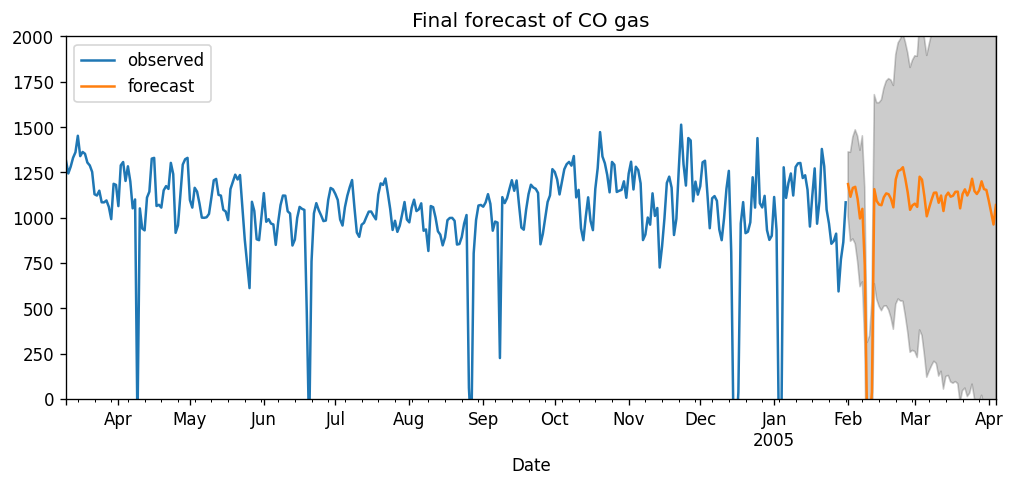

In [421]:
# Visualising my final prediction of CO gas
ax = df_CO['CO'].plot(figsize=(10, 4))
pred_CO_final.predicted_mean.plot(ax=ax)
ax.fill_between(pred_CO_final.conf_int().index,
                pred_CO_final.conf_int().iloc[:, 0],
                pred_CO_final.conf_int().iloc[:, 1], color='k', alpha=.2)
ax.set(ylim=(0,2000))
plt.title("Final forecast of CO gas")
plt.legend(loc=2, labels=['observed', 'forecast'])
plt.show()

# Analysis on NMHC Gas

In [422]:
# Get NMHC gas train.csv data
df_NMHC = pd.DataFrame(train_pivot["T"]["NMHC"])
df_NMHC = pd.concat([df_NMHC, train_pivot["RH"]["NMHC"]], axis=1)
df_NMHC = pd.concat([df_NMHC, train_pivot["Value"]["NMHC"]], axis=1)
df_NMHC.columns = ['T','RH','NMHC']
df_NMHC.head()

T         RH         NMHC
Date                                         
2004-03-10  12.020833  54.883334   912.250000
2004-03-11   9.833333  64.069791   851.802083
2004-03-12  11.292708  51.107292  1008.229167
2004-03-13  12.866319  51.530903   992.822917
2004-03-14  16.016667  48.843750   943.854167

In [423]:
# Get NMHC gas test data
testdf_NMHC = test_dataset.loc[test_dataset['Gas'] == 'NMHC']
testdf_NMHC.head()

id         T         RH   Gas
Date                                     
2005-02-01  63  6.616667  51.734375  NMHC
2005-02-02  64  7.613194  43.930903  NMHC
2005-02-03  65  7.252083  50.966667  NMHC
2005-02-04  66  7.473611  50.166319  NMHC
2005-02-05  67  5.571875  46.604167  NMHC

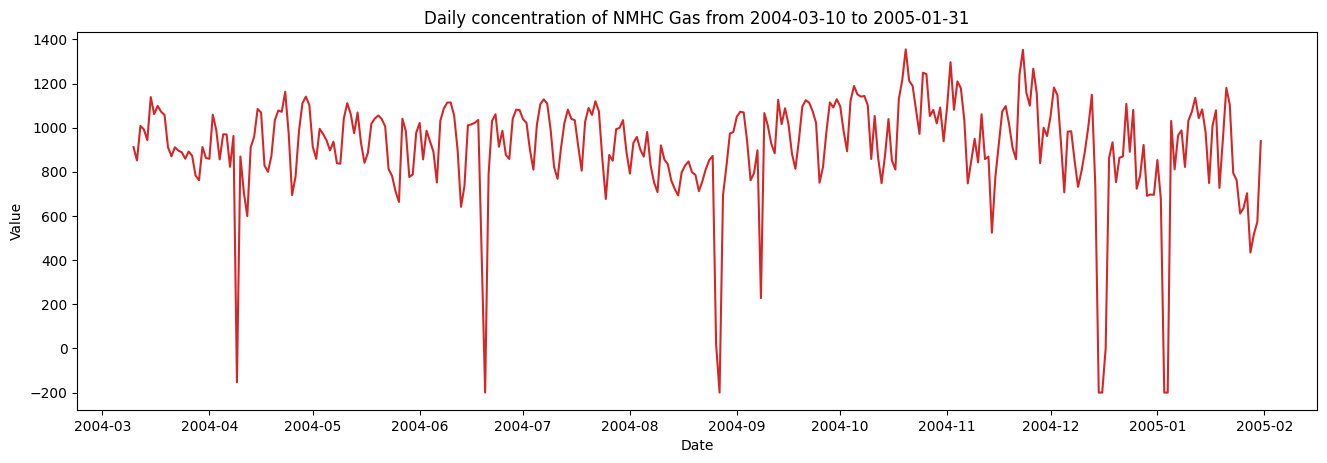

In [424]:
plot_df(df=df_NMHC, x=df_NMHC.index, y=df_NMHC['NMHC'], title='Daily concentration of NMHC Gas from 2004-03-10 to 2005-01-31')    

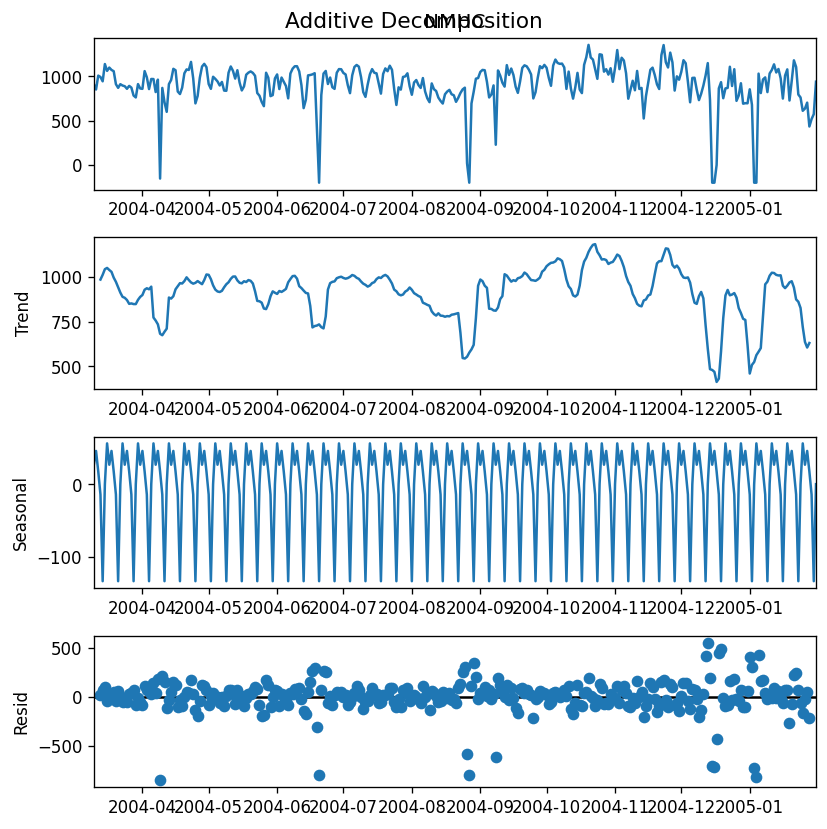

In [425]:
#Time Series Decomposition

# Additive Decomposition
result_add_NMHC = seasonal_decompose(df_NMHC['NMHC'], model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (7,7)})
result_add_NMHC.plot().suptitle('Additive Decomposition', fontsize=13)
plt.show()

## We see that NMHC gas does not have an obvious trend but has a clear seasonality as well.

In [426]:
# Time series appear to be stationary
adftest = adfuller(df_NMHC['NMHC'])
print('number of observation:', adftest[3], '\np-value:', adftest[1])

number of observation: 326 
p-value: 1.2969233009593514e-16


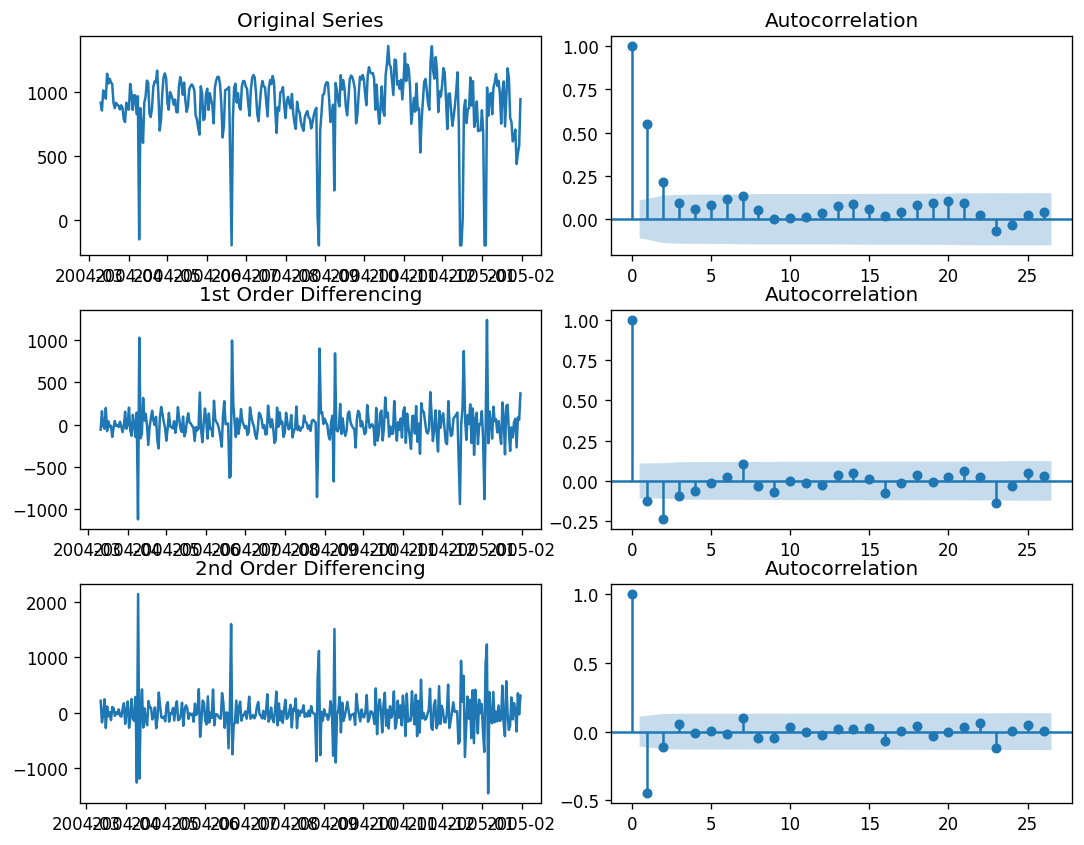

In [427]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(df_NMHC['NMHC']); axes[0, 0].set_title('Original Series')
plot_acf(df_NMHC['NMHC'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_NMHC['NMHC'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_NMHC['NMHC'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_NMHC['NMHC'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_NMHC['NMHC'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## The ACF of the 1st differenced series tells us that lags 1 and 2 are significant to the model. I'll go with q=1 for now.

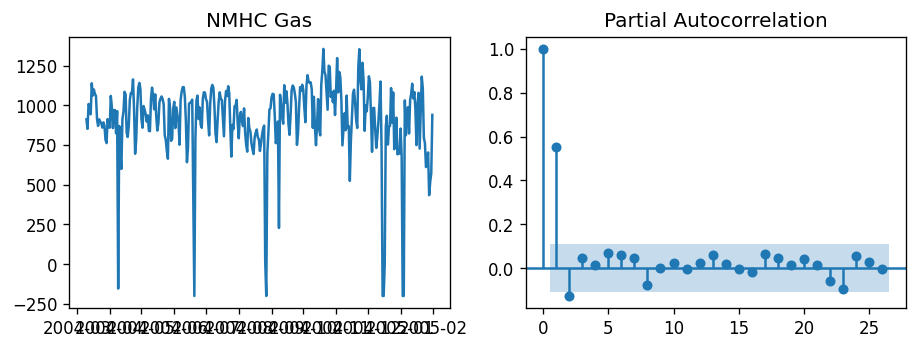

In [428]:
# PACF plot of NMHC gas
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_NMHC['NMHC']); axes[0].set_title('NMHC Gas')
plot_pacf(df_NMHC['NMHC'].dropna(), ax=axes[1])

plt.show()

## PACF shows that lag 1 and 2 are significant, bu1 I'll go with p=1 for now.

##

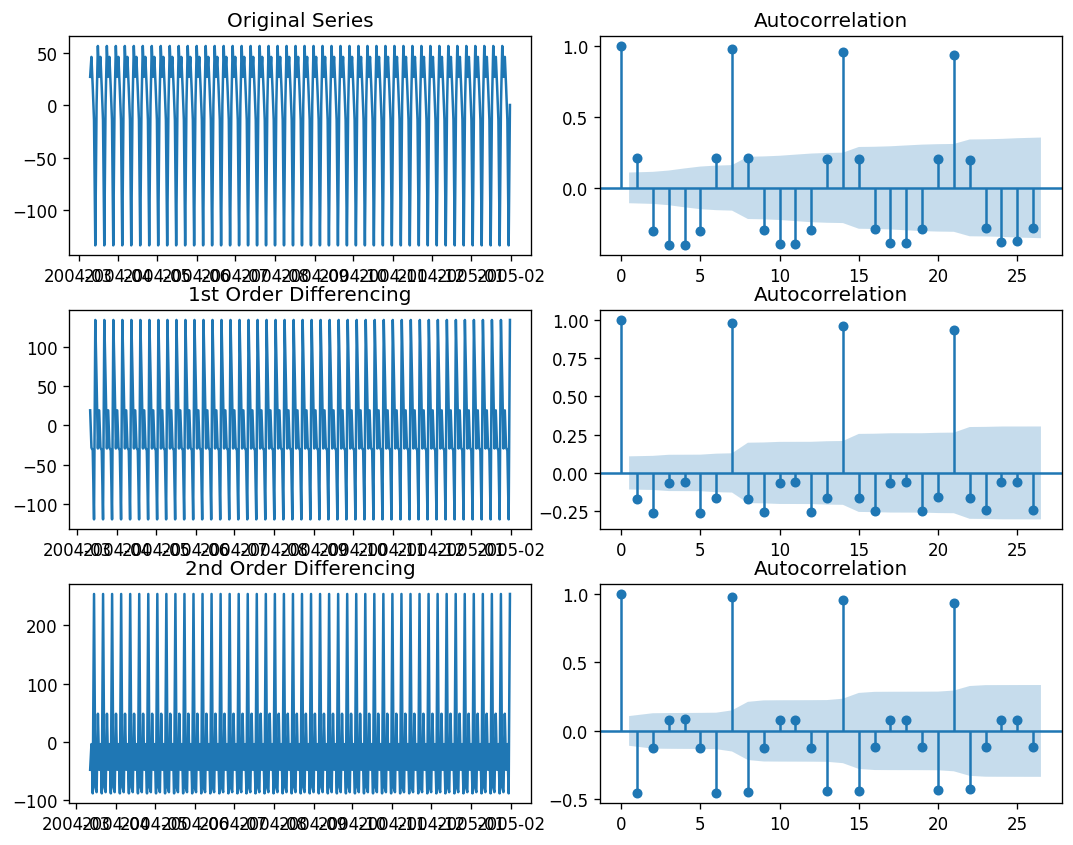

In [429]:
# ACF plots of seasonality of NMHC gas
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(result_add_NMHC.seasonal); axes[0, 0].set_title('Original Series')
plot_acf(result_add_NMHC.seasonal, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(result_add_NMHC.seasonal.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(result_add_NMHC.seasonal.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(result_add_NMHC.seasonal.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(result_add_NMHC.seasonal.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## ACF of seasonality shows lag 1 and 2 are significant, but I'll go with Q=1 for now.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


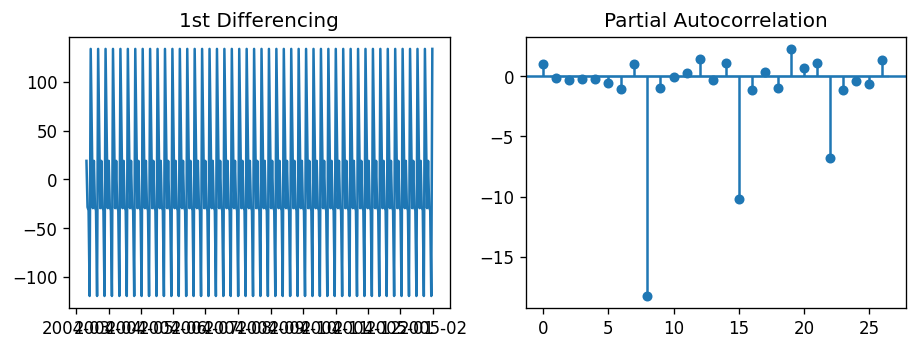

In [430]:
# PACF plot of 1st differenced seasonality of NMHC gas
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(result_add_NMHC.seasonal.diff()); axes[0].set_title('1st Differencing')
plot_pacf(result_add_NMHC.seasonal.diff().dropna(), ax=axes[1])

plt.show()

## PACF of seasonality shows the first significant lag at lag 8, so I'll go with P=0 for now.

In [431]:
# Split train and test data
train_NMHC = df_NMHC['NMHC'].loc['2004-03-10':'2004-10-10']
test_NMHC = df_NMHC['NMHC'].loc['2004-10-11':'2005-01-31']
exog_train_NMHC = df_NMHC[['T']].loc['2004-03-10':'2004-10-10']
exog_forecast_NMHC = df_NMHC[['T']].loc['2004-10-11':'2005-01-31']

## This time I only passed 'T' into the exog variables as 'RH' did not help with the model accuracy.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


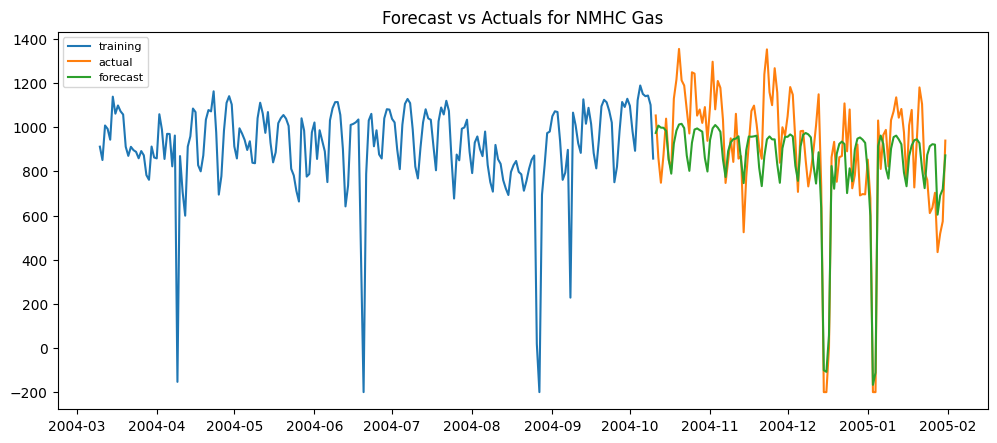

In [432]:
# Build Model
model_NMHC = SARIMAX(train_NMHC, order=(1,0,1),
                      seasonal_order=(0,1,1,7), exog=exog_train_NMHC) 
fitted_NMHC = model_NMHC.fit()  

pred_NMHC = fitted_NMHC.get_prediction(start=pd.to_datetime('2004-03-10'),
                                  end=pd.to_datetime('2005-01-31'), exog=exog_forecast_NMHC).predicted_mean
fc_series_NMHC = pd.Series(pred_NMHC.loc['2004-10-11':'2005-01-31'], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_NMHC, label='training')
plt.plot(test_NMHC, label='actual')
plt.plot(fc_series_NMHC, label='forecast')
plt.title('Forecast vs Actuals for NMHC Gas')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [433]:
fitted_NMHC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              NMHC   No. Observations:                  215
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1192.537
Date:                           Fri, 13 Aug 2021   AIC                           2395.073
Time:                                   20:23:04   BIC                           2411.761
Sample:                               03-10-2004   HQIC                          2401.821
                                    - 10-10-2004                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              5.0158      0.132     38.042      0.000       4.757       5.274
ar.L1          0.7062      0.074      9.491      0.000       0.560       0.852
ma.L1         -0.0142      0.111     -0.128      0.898      -0.232       0.203
ma.S.L7       -0.9102      0.054    -17.011      0.000      -1.015      -0.805
sigma2      5278.2517    542.449      9.730      0.000    4215.070    6341.433
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.95   Prob(JB):                         0.85
Heteroskedasticity (H):               0.85   Skew:                            -0.09
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 'T' has a very high coefficient and low p-value, showing that it is very helpful in helping the model to predict NMHC gas concentrations.

In [434]:
# calculate MAPE for both training and testing data
from sklearn.metrics import mean_absolute_percentage_error
MAPE_training_NMHC = mean_absolute_percentage_error(train_NMHC, pred_NMHC.loc['2004-03-10':'2004-10-10'])
MAPE_testing_NMHC = mean_absolute_percentage_error(test_NMHC, pred_NMHC.loc['2004-10-11':'2005-01-31'])
print(f'Training Error is: {MAPE_training_NMHC*100:.2f}%')
print(f'Testing Error is: {MAPE_testing_NMHC*100:.2f}%')

Training Error is: 10.64%
Testing Error is: 261.38%


In [435]:
# Fit the final model on all NMHC gas values in train.csv
sarimax_model_NMHC = SARIMAX(df_NMHC['NMHC'], order=(1,0,1), 
                      seasonal_order=(0,1,1,7), exog=df_NMHC[['T']]).fit()
sarimax_model_NMHC.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              NMHC   No. Observations:                  328
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1924.196
Date:                           Fri, 13 Aug 2021   AIC                           3858.393
Time:                                   20:23:05   BIC                           3877.250
Sample:                               03-10-2004   HQIC                          3865.922
                                    - 01-31-2005                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              5.2673      0.165     31.958      0.000       4.944       5.590
ar.L1          0.6404      0.062     10.266      0.000       0.518       0.763
ma.L1          0.0474      0.075      0.634      0.526      -0.099       0.194
ma.S.L7       -0.9113      0.027    -34.142      0.000      -0.964      -0.859
sigma2      9071.5251    661.487     13.714      0.000    7775.034    1.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.77
Prob(Q):                              0.99   Prob(JB):                         0.06
Heteroskedasticity (H):               2.69   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [436]:
exog_forecast_NMHC_final = testdf_NMHC[['T']]
exog_forecast_NMHC_final

T
Date                 
2005-02-01   6.616667
2005-02-02   7.613194
2005-02-03   7.252083
2005-02-04   7.473611
2005-02-05   5.571875
...               ...
2005-03-31  17.554167
2005-04-01  15.919792
2005-04-02  15.489583
2005-04-03  18.381250
2005-04-04  16.966667

[63 rows x 1 columns]

In [437]:
pred_NMHC_final = sarimax_model_NMHC.get_prediction(start=pd.to_datetime('2005-02-01'),
                                  end=pd.to_datetime('2005-04-04'), exog=exog_forecast_NMHC_final)

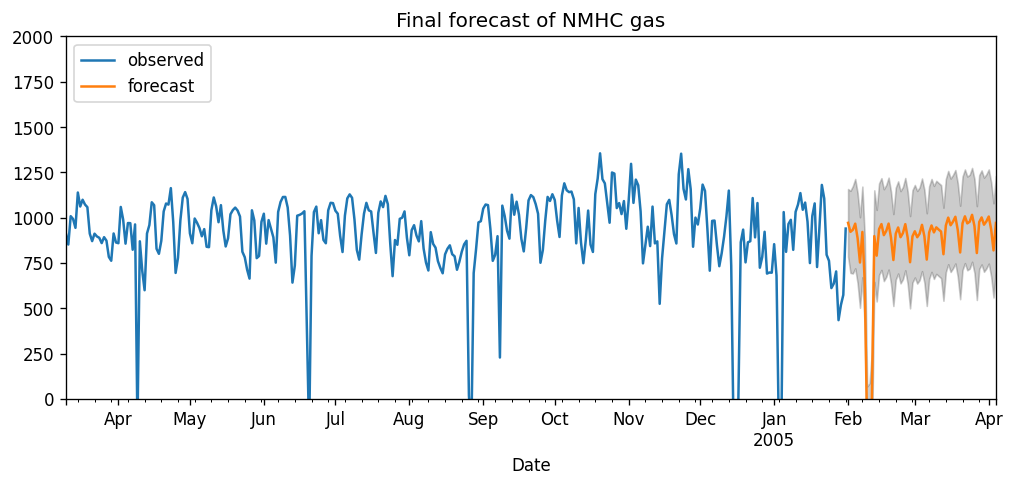

In [438]:
ax = df_NMHC['NMHC'].plot(figsize=(10, 4))
pred_NMHC_final.predicted_mean.plot(ax=ax)
ax.fill_between(pred_NMHC_final.conf_int().index,
                pred_NMHC_final.conf_int().iloc[:, 0],
                pred_NMHC_final.conf_int().iloc[:, 1], color='k', alpha=.2)
ax.set(ylim=(0,2000))
plt.legend(loc=2, labels=['observed', 'forecast'])
plt.title("Final forecast of NMHC gas")
plt.show()

# Analysis on NOx Gas

In [439]:
# Get NOx gas train.csv data
df_NOX = pd.DataFrame(train_pivot["T"]["NOx"])
df_NOX = pd.concat([df_NOX, train_pivot["RH"]["NOx"]], axis=1)
df_NOX = pd.concat([df_NOX, train_pivot["Value"]["NOx"]], axis=1)
df_NOX.columns = ['T','RH','NOx']
df_NOX.head()

T         RH          NOx
Date                                         
2004-03-10  12.020833  54.883334  1167.250000
2004-03-11   9.833333  64.069791  1277.187500
2004-03-12  11.292708  51.107292  1101.718750
2004-03-13  12.866319  51.530903   993.159722
2004-03-14  16.016667  48.843750  1001.104167

In [440]:
# Get NOx gas test data
testdf_NOX = test_dataset.loc[test_dataset['Gas'] == 'NOx']
testdf_NOX.head()

id         T         RH  Gas
Date                                     
2005-02-01  126  6.616667  51.734375  NOx
2005-02-02  127  7.613194  43.930903  NOx
2005-02-03  128  7.252083  50.966667  NOx
2005-02-04  129  7.473611  50.166319  NOx
2005-02-05  130  5.571875  46.604167  NOx

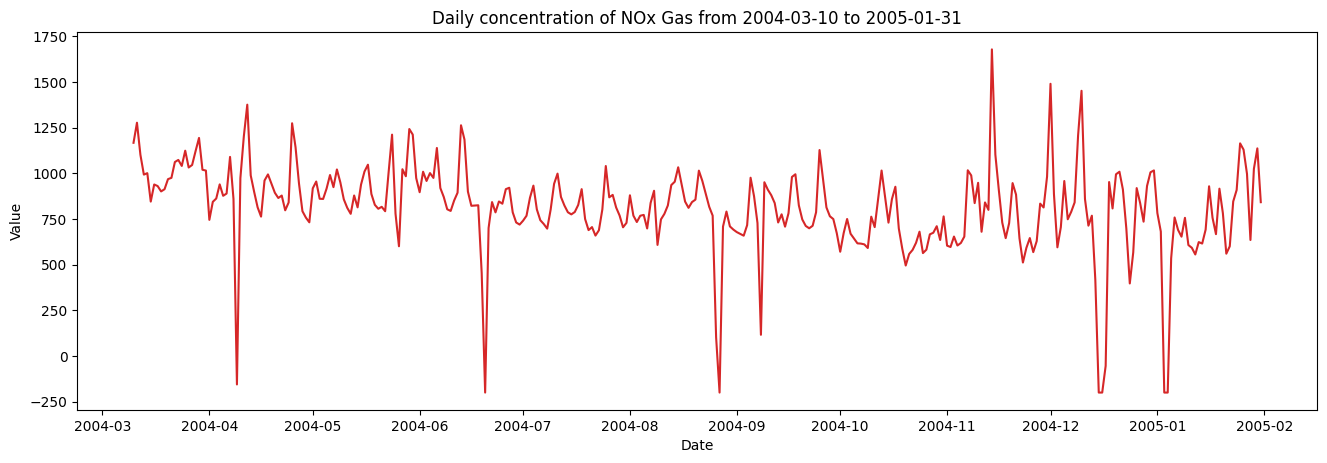

In [441]:
plot_df(df=df_NOX, x=df_NOX.index, y=df_NOX['NOx'], title='Daily concentration of NOx Gas from 2004-03-10 to 2005-01-31')  

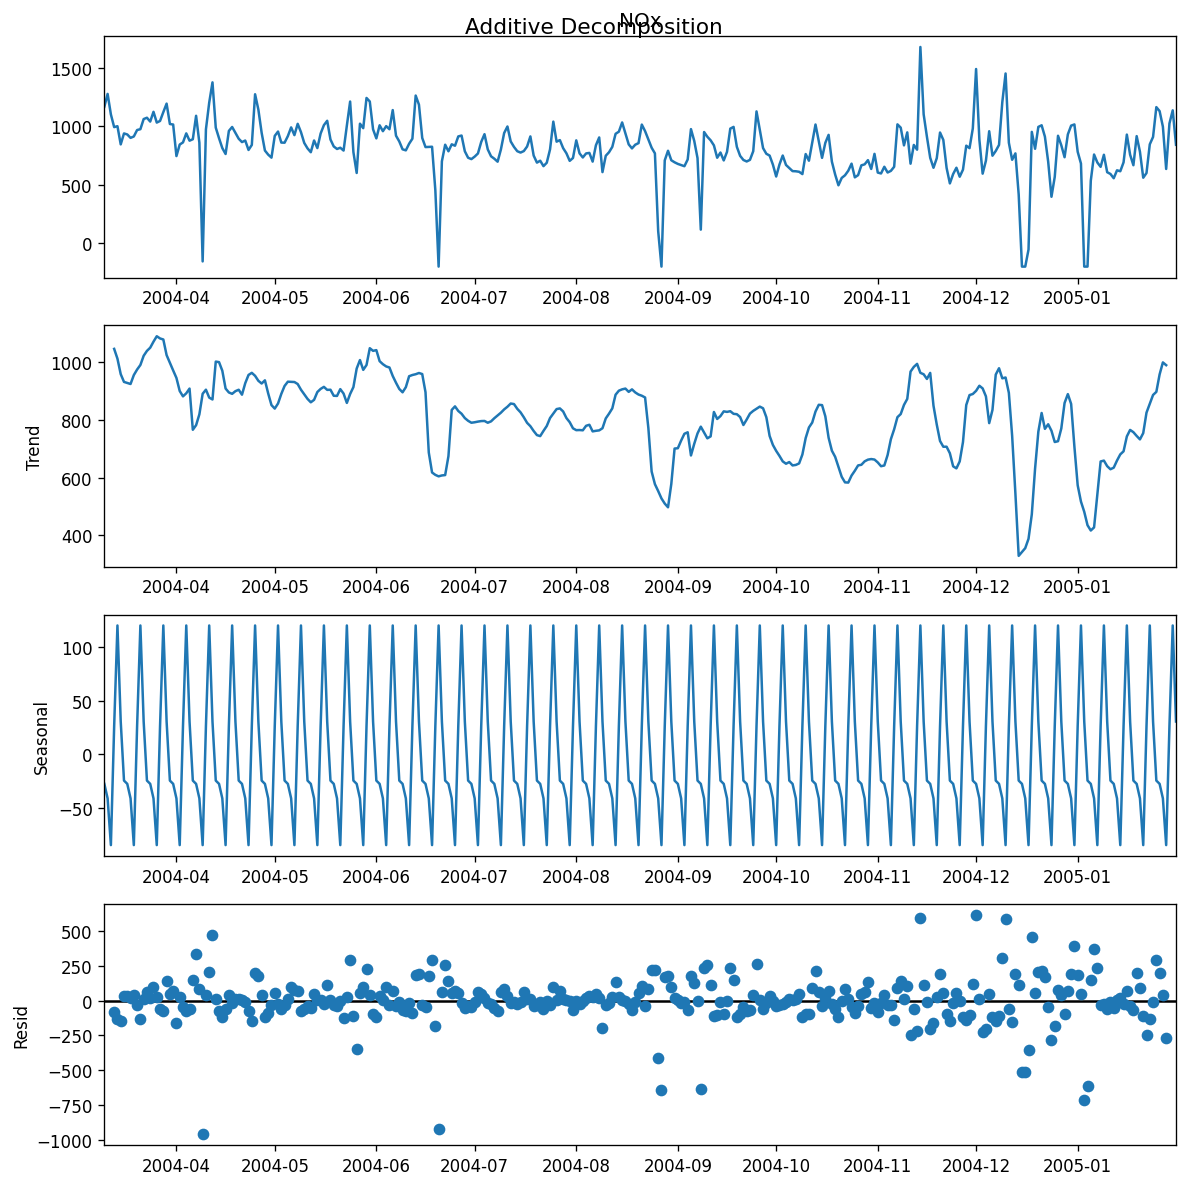

In [442]:
#Time Series Decomposition

# Additive Decomposition
result_add_NOX = seasonal_decompose(df_NOX['NOx'], model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add_NOX.plot().suptitle('Additive Decomposition', fontsize=13)
plt.show()

In [443]:
# Time series appear to be stationary
adftest = adfuller(df_NOX['NOx'])
print('number of observation:', adftest[3], '\np-value:', adftest[1])

number of observation: 326 
p-value: 1.3789239001930934e-17


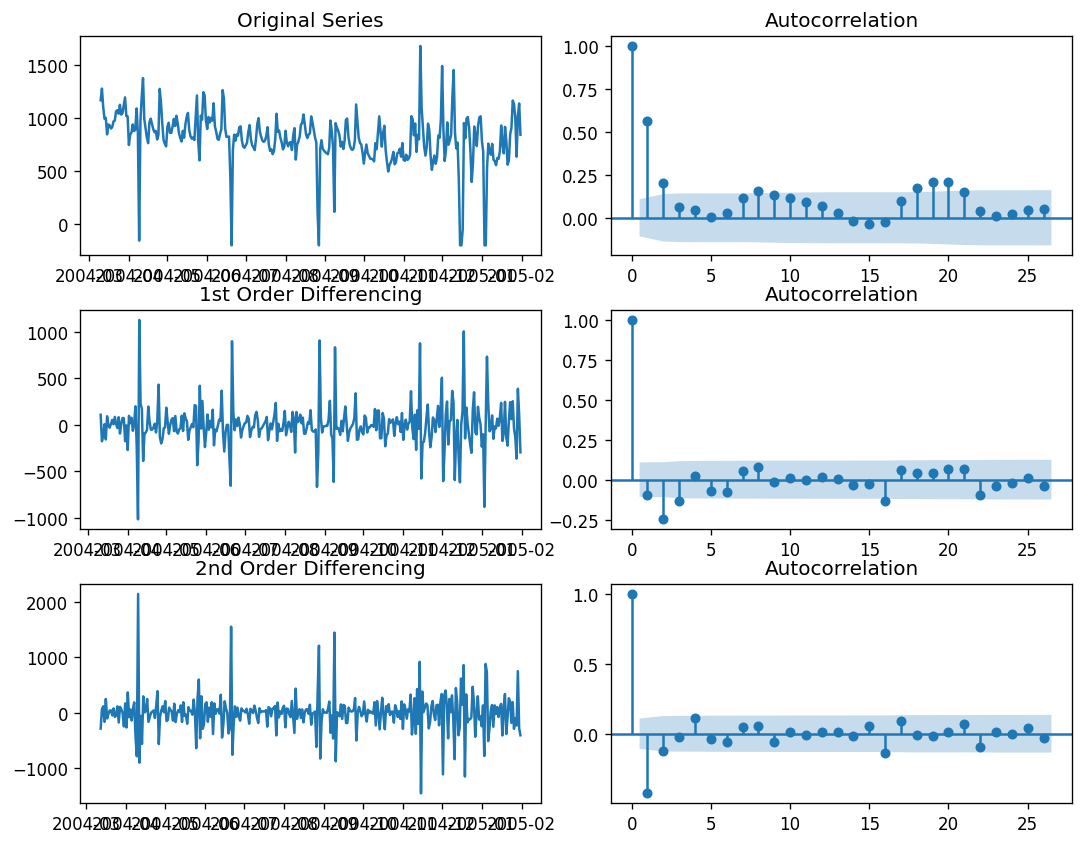

In [444]:
# ACF Plot for Nox Gas
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(df_NOX['NOx']); axes[0, 0].set_title('Original Series')
plot_acf(df_NOX['NOx'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_NOX['NOx'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_NOX['NOx'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_NOX['NOx'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_NOX['NOx'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## For NOx gas, I decided to go with d=0. Lags 1 and 2 of the ACF of the series are significant, so I'll go with q=2.

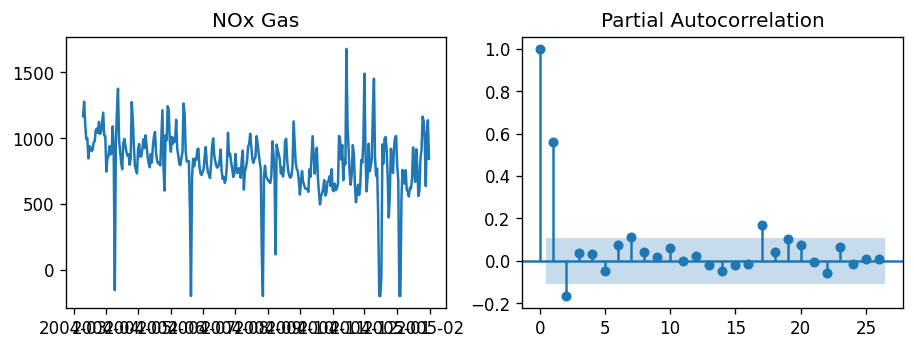

In [445]:
# PACF plot of NOx series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_NOX['NOx']); axes[0].set_title('NOx Gas')
plot_pacf(df_NOX['NOx'].dropna(), ax=axes[1])

plt.show()

## From PACF of the undifferenced series, lags 1 and 2 are signficant, so I'll go with p=2.

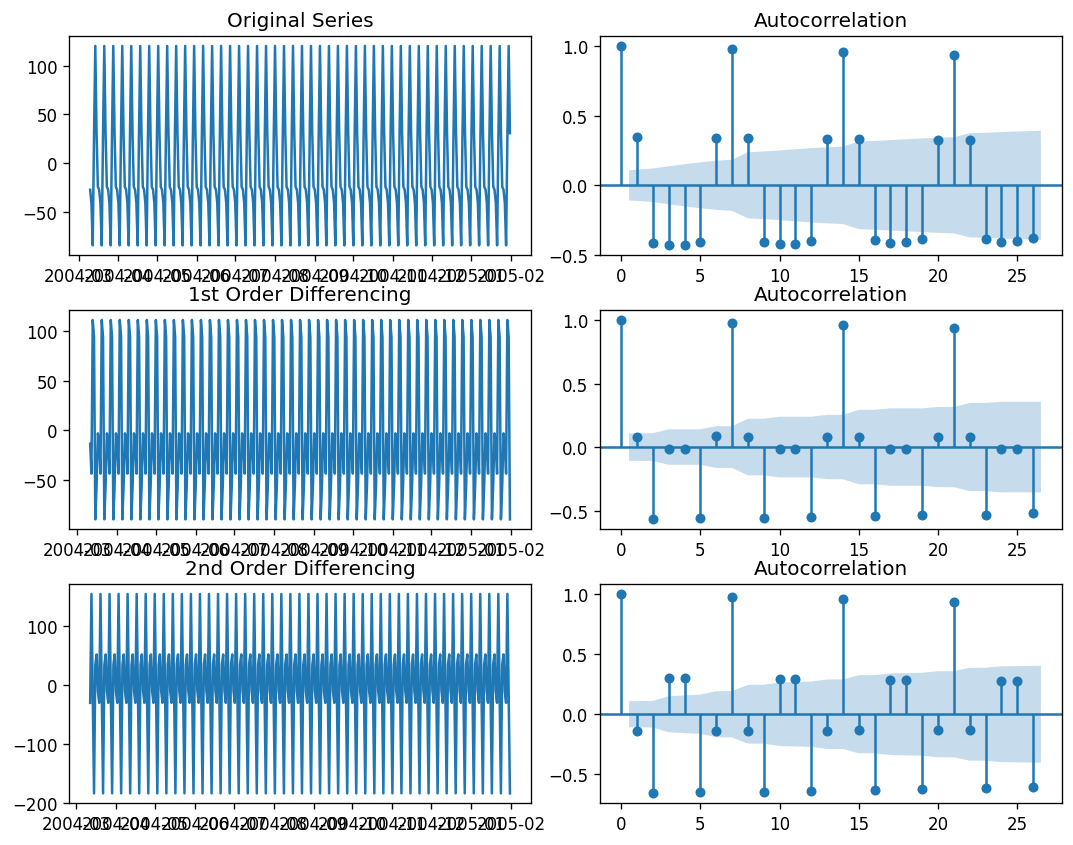

In [446]:
# ACF plots of seasonality of NOx gas
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(result_add_NOX.seasonal); axes[0, 0].set_title('Original Series')
plot_acf(result_add_NOX.seasonal, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(result_add_NOX.seasonal.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(result_add_NOX.seasonal.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(result_add_NOX.seasonal.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(result_add_NOX.seasonal.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## For ACF of first differenced seasonality, lags 2 and 5 are significant, so I'll go with q=2 for now.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


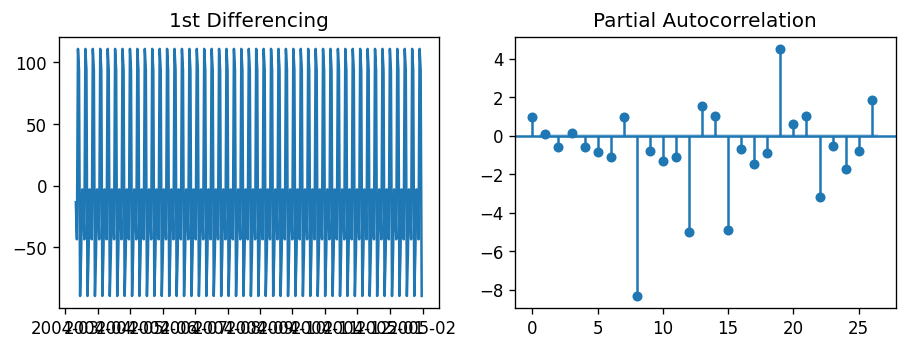

In [447]:
# PACF plot of 1st differenced seasonality of NOx gas
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(result_add_NOX.seasonal.diff()); axes[0].set_title('1st Differencing')
plot_pacf(result_add_NOX.seasonal.diff().dropna(), ax=axes[1])

plt.show()

## PACF of 1st differenced seasonality only shows significant lags at lag 8, so I'll go with p=0.

In [448]:
# Split train and test data
train_NOX = df_NOX['NOx'].loc['2004-03-10':'2004-10-10']
test_NOX = df_NOX['NOx'].loc['2004-10-11':'2005-01-31']
exog_train_NOX = df_NOX[['T','RH']].loc['2004-03-10':'2004-10-10']
exog_forecast_NOX = df_NOX[['T','RH']].loc['2004-10-11':'2005-01-31']

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

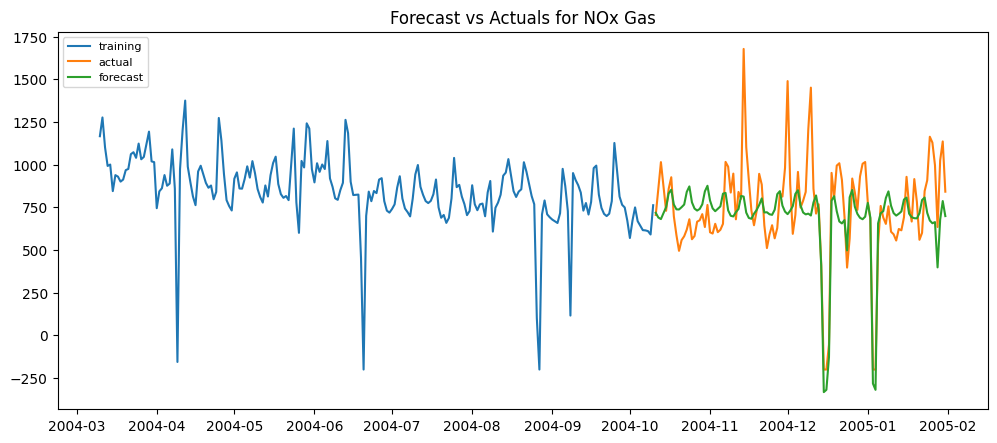

In [449]:
# Build Model
model_NOX = SARIMAX(train_NOX, order=(2,0,2),
                      seasonal_order=(0,1,2,7), exog=exog_train_NOX) 
fitted_NOX = model_NOX.fit()  

pred_NOX = fitted_NOX.get_prediction(start=pd.to_datetime('2004-03-10'),
                                  end=pd.to_datetime('2005-01-31'), exog=exog_forecast_NOX).predicted_mean
fc_series_NOX = pd.Series(pred_NOX.loc['2004-10-11':'2005-01-31'], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_NOX, label='training')
plt.plot(test_NOX, label='actual')
plt.plot(fc_series_NOX, label='forecast')
plt.title('Forecast vs Actuals for NOx Gas')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [450]:
fitted_NOX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               NOx   No. Observations:                  215
Model:             SARIMAX(2, 0, 2)x(0, 1, 2, 7)   Log Likelihood               -1242.791
Date:                           Fri, 13 Aug 2021   AIC                           2503.582
Time:                                   20:23:17   BIC                           2533.620
Sample:                               03-10-2004   HQIC                          2515.728
                                    - 10-10-2004                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              3.5259      0.876      4.025      0.000       1.809       5.243
RH             1.0806      0.778      1.388      0.165      -0.445       2.606
ar.L1         -0.3490      0.120     -2.920      0.004      -0.583      -0.115
ar.L2          0.5813      0.087      6.648      0.000       0.410       0.753
ma.L1          1.1145      0.144      7.725      0.000       0.832       1.397
ma.L2          0.1287      0.129      0.996      0.319      -0.124       0.382
ma.S.L7       -0.8640      0.070    -12.277      0.000      -1.002      -0.726
ma.S.L14       0.0351      0.063      0.559      0.576      -0.088       0.158
sigma2      8730.9488    821.695     10.626      0.000    7120.456    1.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                28.31
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.66
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [451]:
# calculate MAPE for both training and testing data
MAPE_training_NOX = mean_absolute_percentage_error(train_NOX, pred_NOX.loc['2004-03-10':'2004-10-10'])
MAPE_testing_NOX = mean_absolute_percentage_error(test_NOX, pred_NOX.loc['2004-10-11':'2005-01-31'])
print(f'Training Error is: {MAPE_training_NOX*100:.2f}%')
print(f'Testing Error is: {MAPE_testing_NOX*100:.2f}%')

Training Error is: 12.29%
Testing Error is: 22.28%


In [452]:
sarimax_model_NOX = SARIMAX(df_NOX['NOx'], order=(2,0,2), 
                      seasonal_order=(0,1,2,7), exog=df_NOX[['T','RH']]).fit()
sarimax_model_NOX.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               NOx   No. Observations:                  328
Model:             SARIMAX(2, 0, 2)x(0, 1, 2, 7)   Log Likelihood               -2015.092
Date:                           Fri, 13 Aug 2021   AIC                           4048.184
Time:                                   20:23:21   BIC                           4082.127
Sample:                               03-10-2004   HQIC                          4061.736
                                    - 01-31-2005                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              5.7394      0.962      5.964      0.000       3.853       7.626
RH            -1.0140      0.817     -1.241      0.214      -2.615       0.587
ar.L1         -0.4148      0.173     -2.402      0.016      -0.753      -0.076
ar.L2          0.5582      0.093      6.008      0.000       0.376       0.740
ma.L1          1.1418      0.184      6.222      0.000       0.782       1.502
ma.L2          0.1530      0.096      1.586      0.113      -0.036       0.342
ma.S.L7       -0.9400      0.051    -18.570      0.000      -1.039      -0.841
ma.S.L14       0.0622      0.054      1.146      0.252      -0.044       0.169
sigma2      1.608e+04    662.962     24.251      0.000    1.48e+04    1.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1217.15
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.49   Skew:                             1.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [453]:
exog_forecast_NOX_final = testdf_NOX[['T','RH']]
pred_NOX_final = sarimax_model_NOX.get_prediction(start=pd.to_datetime('2005-02-01'),
                                  end=pd.to_datetime('2005-04-04'), exog=exog_forecast_NOX_final)

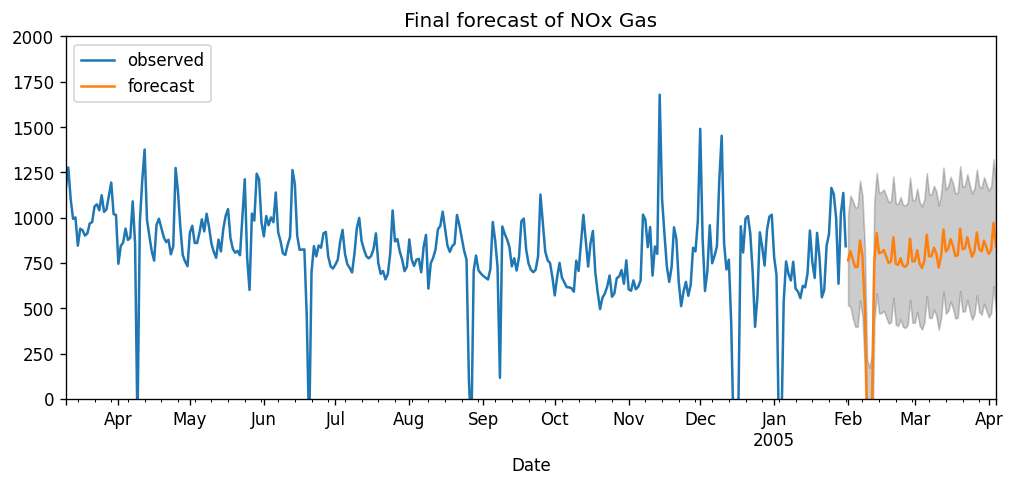

In [454]:
ax = df_NOX['NOx'].plot(figsize=(10, 4))
pred_NOX_final.predicted_mean.plot(ax=ax)
ax.fill_between(pred_NOX_final.conf_int().index,
                pred_NOX_final.conf_int().iloc[:, 0],
                pred_NOX_final.conf_int().iloc[:, 1], color='k', alpha=.2)
ax.set(ylim=(0,2000))
plt.title("Final forecast of NOx Gas")
plt.legend(loc=2, labels=['observed', 'forecast'])
plt.show()

# Analysis on O3 Gas

In [455]:
# Get NOx gas train.csv data
df_O3 = pd.DataFrame(train_pivot["T"]["O3"])
df_O3 = pd.concat([df_O3, train_pivot["RH"]["O3"]], axis=1)
df_O3 = pd.concat([df_O3, train_pivot["Value"]["O3"]], axis=1)
df_O3.columns = ['T','RH','O3']
df_O3.head()

T         RH           O3
Date                                         
2004-03-10  12.020833  54.883334  1096.041667
2004-03-11   9.833333  64.069791   885.031250
2004-03-12  11.292708  51.107292  1084.218750
2004-03-13  12.866319  51.530903  1245.781250
2004-03-14  16.016667  48.843750  1234.177083

In [456]:
# Get NOx gas test data
testdf_O3 = test_dataset.loc[test_dataset['Gas'] == 'O3']
testdf_O3.head()

id         T         RH Gas
Date                                    
2005-02-01  189  6.616667  51.734375  O3
2005-02-02  190  7.613194  43.930903  O3
2005-02-03  191  7.252083  50.966667  O3
2005-02-04  192  7.473611  50.166319  O3
2005-02-05  193  5.571875  46.604167  O3

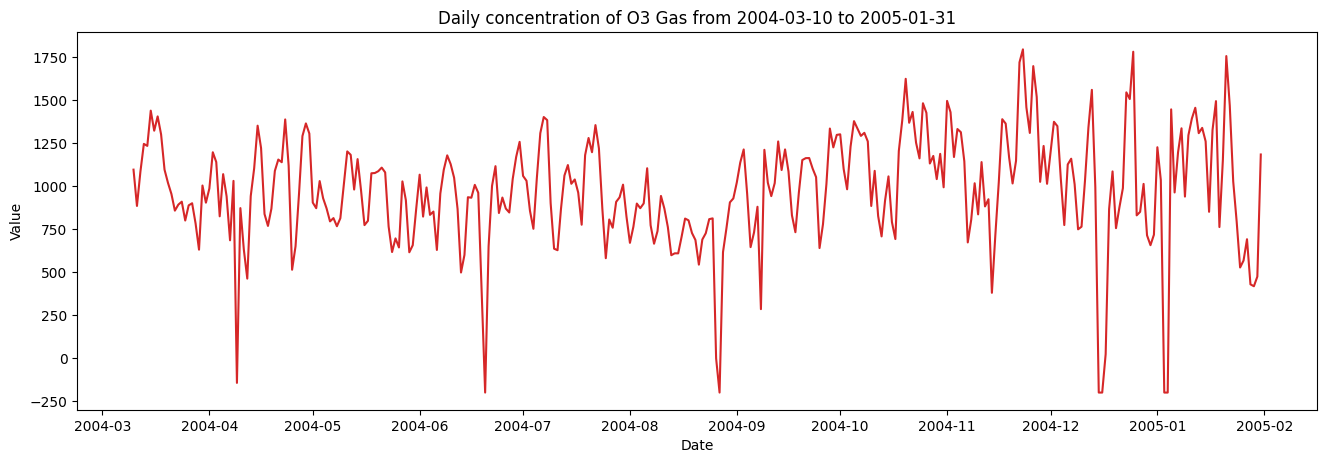

In [457]:
plot_df(df=df_O3, x=df_O3.index, y=df_O3['O3'], title='Daily concentration of O3 Gas from 2004-03-10 to 2005-01-31')  

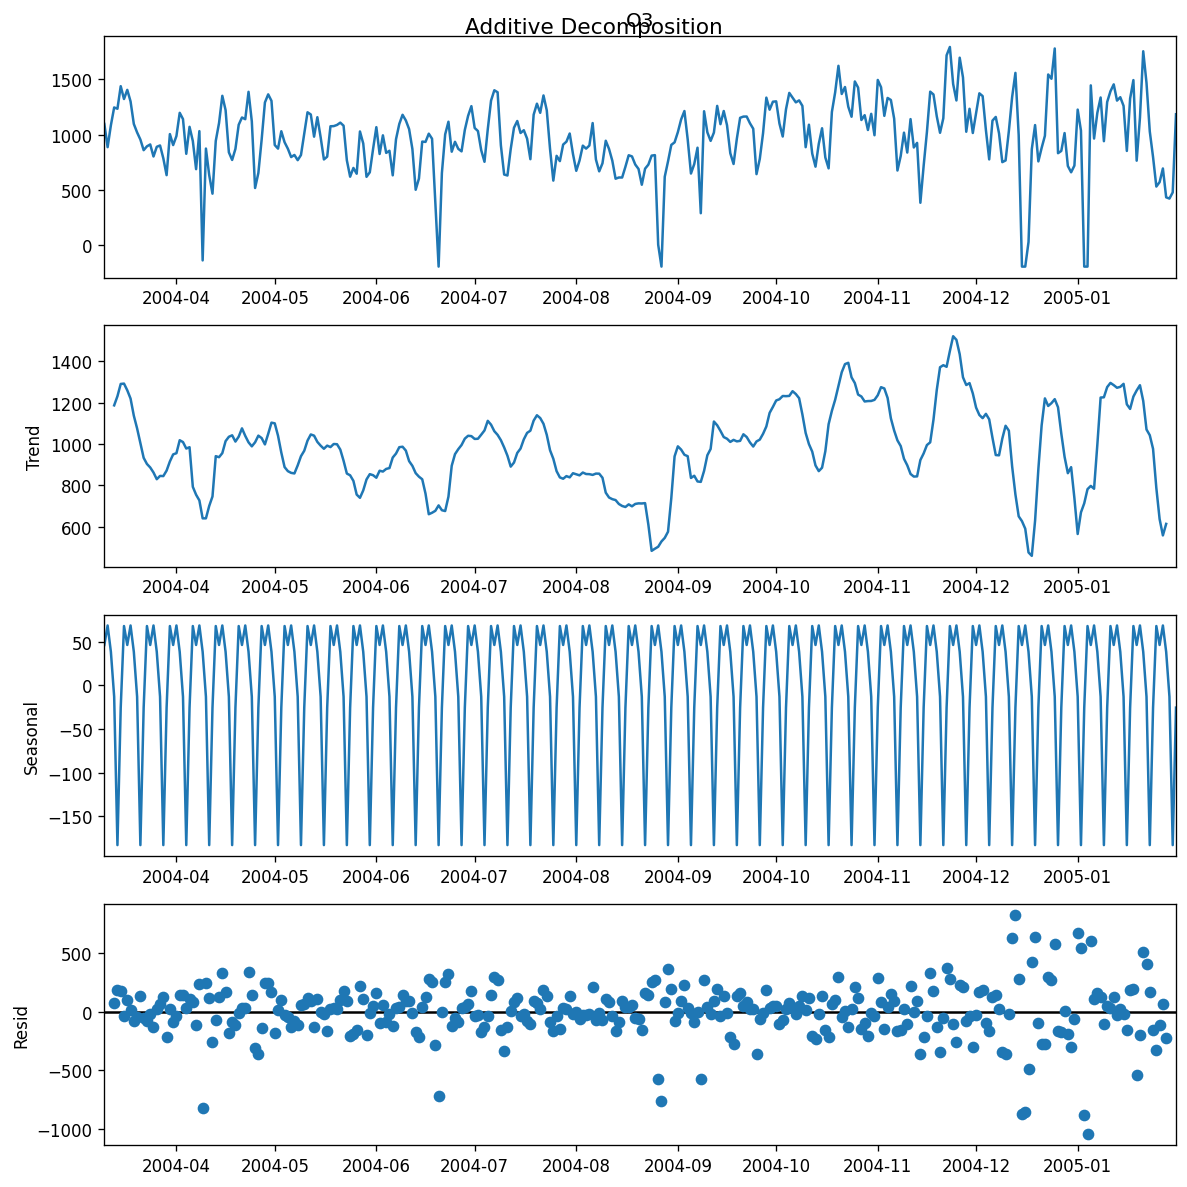

In [458]:
#Time Series Decomposition

# Additive Decomposition
result_add_O3 = seasonal_decompose(df_O3['O3'], model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add_O3.plot().suptitle('Additive Decomposition', fontsize=13)
plt.show()

## O3 gas has no obvious trend but a clear seasonality again.

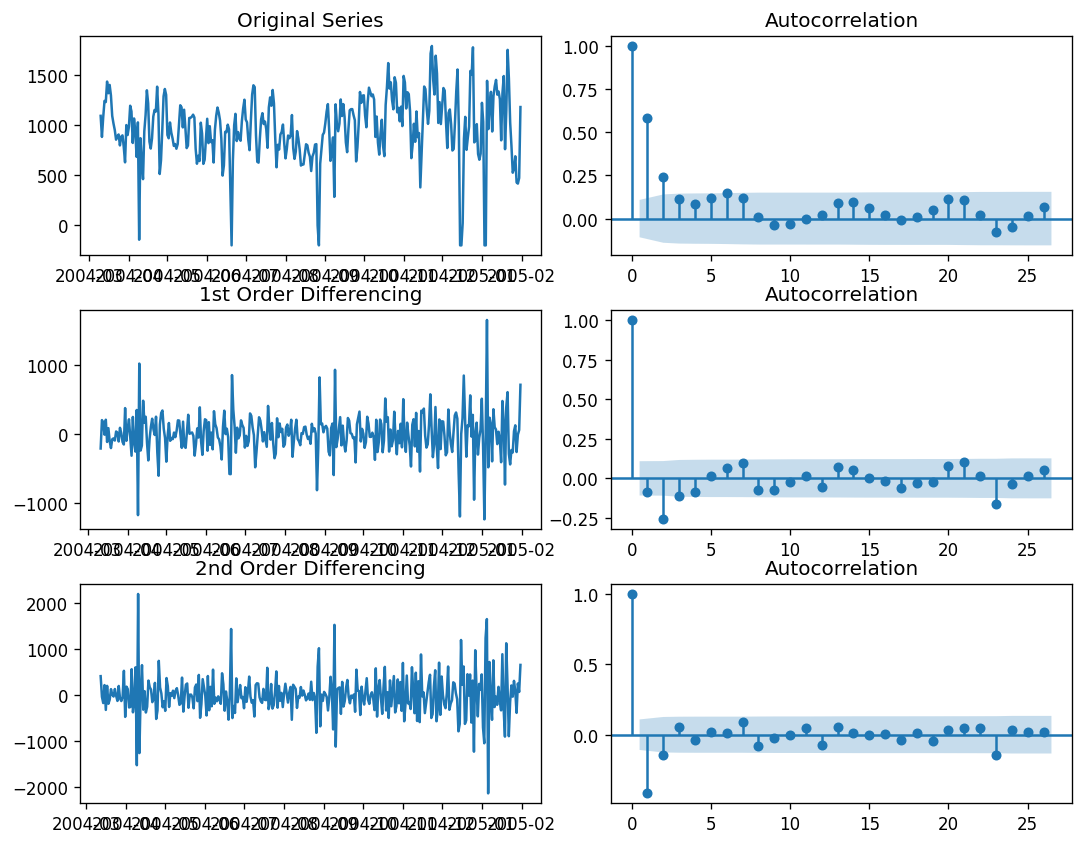

In [459]:
# ACF Plot for O3 Gas
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(df_O3['O3']); axes[0, 0].set_title('Original Series')
plot_acf(df_O3['O3'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_O3['O3'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_O3['O3'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_O3['O3'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_O3['O3'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## ACF of O3 gas shows significant lags at lag 1 and 2, so I'll go with q=2.

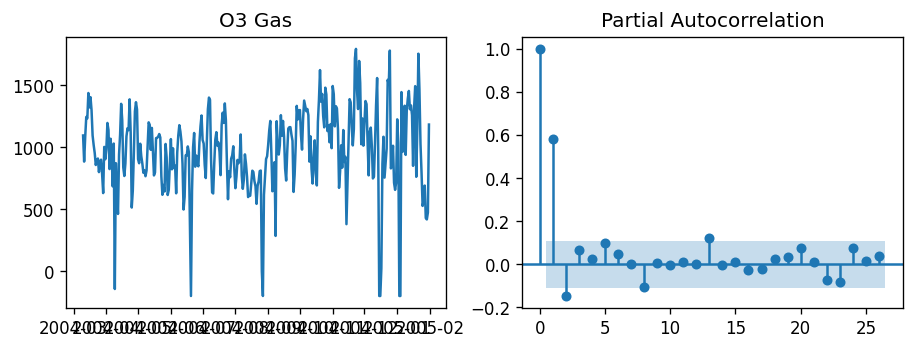

In [460]:
# PACF plot of O3 Gas
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_O3['O3']); axes[0].set_title('O3 Gas')
plot_pacf(df_O3['O3'].dropna(), ax=axes[1])

plt.show()

## PACF of O3 gas shows significant lags at lag 1 and 2, but I'll go with p=1 for now.

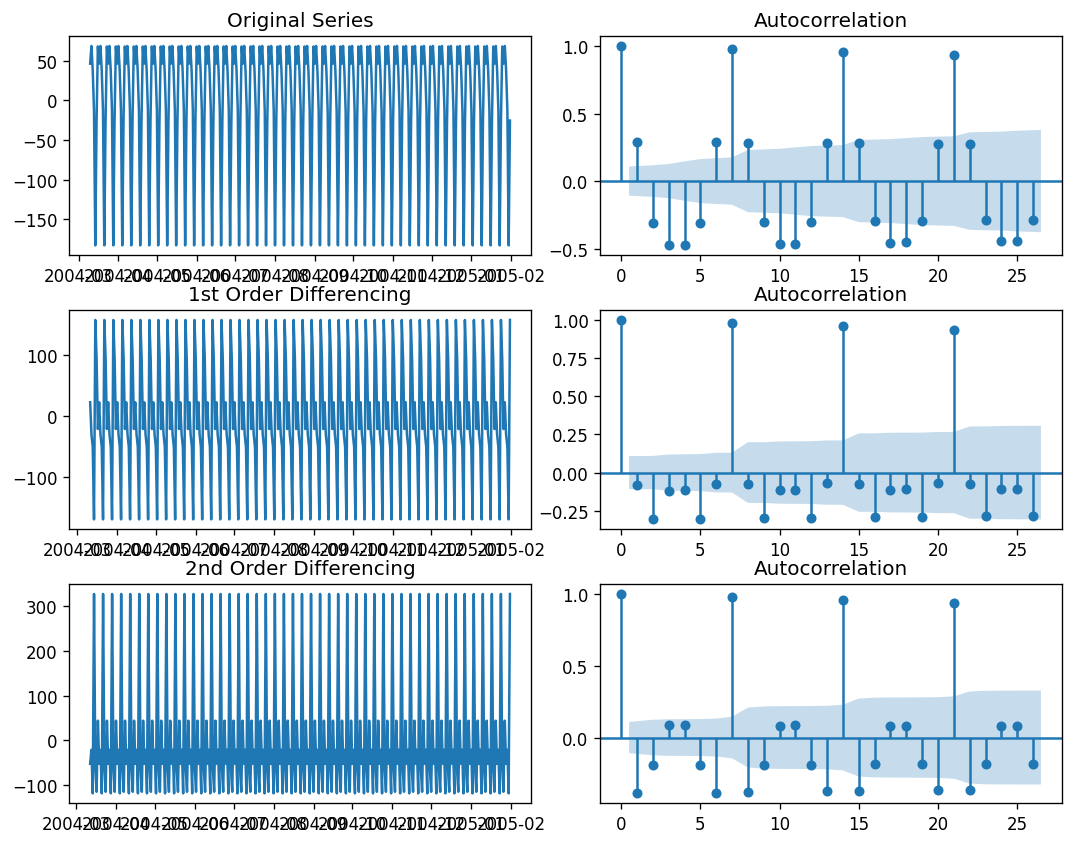

In [461]:
# ACF plots of seasonality of O3 gas
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(result_add_O3.seasonal); axes[0, 0].set_title('Original Series')
plot_acf(result_add_O3.seasonal, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(result_add_O3.seasonal.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(result_add_O3.seasonal.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(result_add_O3.seasonal.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(result_add_O3.seasonal.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## ACF of 1st differenced seasonality shows significant lags at lag 2 and 5, but I'll go with q=1 for now.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


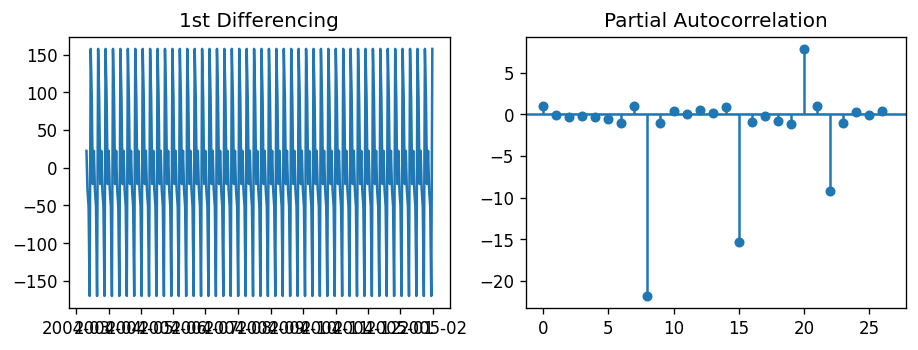

In [462]:
# PACF plot of 1st differenced seasonality of O3 gas
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(result_add_O3.seasonal.diff()); axes[0].set_title('1st Differencing')
plot_pacf(result_add_O3.seasonal.diff().dropna(), ax=axes[1])

plt.show()

## PACF of 1st differenced seasonality shows first significant lag at lag 8, so I'll go with P=0 for now.

In [463]:
# Time series appear to be stationary
adftest = adfuller(df_O3['O3'])
print('number of observation:', adftest[3], '\np-value:', adftest[1])

number of observation: 326 
p-value: 2.3141897708411865e-16


In [464]:
# Split train and test data
train_O3 = df_O3['O3'].loc['2004-03-10':'2004-10-10']
test_O3 = df_O3['O3'].loc['2004-10-11':'2005-01-31']
exog_train_O3 = df_O3[['RH']].loc['2004-03-10':'2004-10-10']
exog_forecast_O3 = df_O3[['RH']].loc['2004-10-11':'2005-01-31']

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


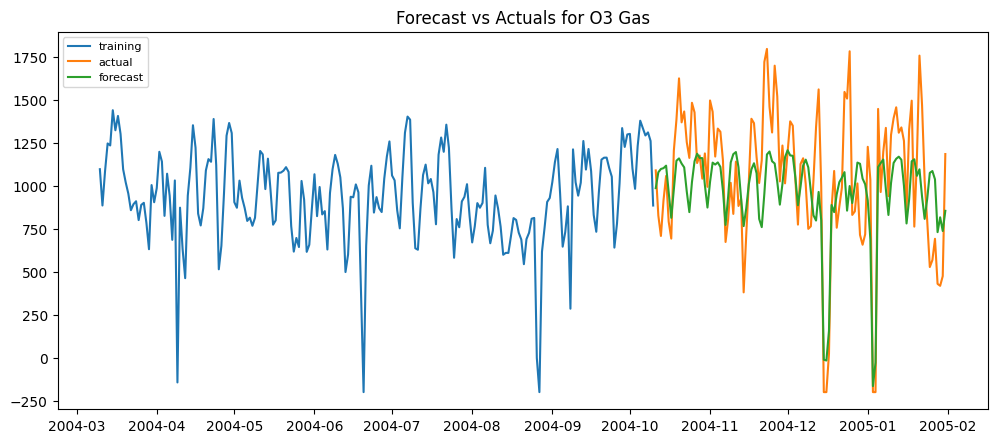

In [465]:
# Build Model  
model_O3 = SARIMAX(train_O3, order=(1,0,2),
                      seasonal_order=(0,1,1,7),exog=exog_train_O3) 
fitted_O3 = model_O3.fit()  

pred_O3 = fitted_O3.get_prediction(start=pd.to_datetime('2004-03-10'),
                                  end=pd.to_datetime('2005-01-31'), exog=exog_forecast_O3).predicted_mean
fc_series_O3 = pd.Series(pred_O3.loc['2004-10-11':'2005-01-31'], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_O3, label='training')
plt.plot(test_O3, label='actual')
plt.plot(fc_series_O3, label='forecast')
plt.title('Forecast vs Actuals for O3 Gas')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [466]:
fitted_O3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  O3   No. Observations:                  215
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -1333.993
Date:                             Fri, 13 Aug 2021   AIC                           2679.987
Time:                                     20:23:33   BIC                           2700.012
Sample:                                 03-10-2004   HQIC                          2688.084
                                      - 10-10-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RH             4.3965      0.287     15.302      0.000       3.833       4.960
ar.L1          0.4995      0.153      3.262      0.001       0.199       0.800
ma.L1          0.2314      0.167      1.388      0.165      -0.095       0.558
ma.L2          0.0635      0.123      0.517      0.605      -0.177       0.304
ma.S.L7       -0.9997      9.205     -0.109      0.914     -19.041      17.042
sigma2      1.952e+04   1.79e+05      0.109      0.913   -3.32e+05    3.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.91   Prob(JB):                         0.41
Heteroskedasticity (H):               0.57   Skew:                            -0.04
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [467]:
# calculate MAPE for both training and testing data
MAPE_training_O3 = mean_absolute_percentage_error(train_O3, pred_O3.loc['2004-03-10':'2004-10-10'])
MAPE_testing_O3 = mean_absolute_percentage_error(test_O3, pred_O3.loc['2004-10-11':'2005-01-31'])
print(f'Training Error is: {MAPE_training_O3*100:.2f}%')
print(f'Testing Error is: {MAPE_testing_O3*100:.2f}%')

Training Error is: 51.19%
Testing Error is: 31.45%


In [468]:
sarimax_model_O3 = SARIMAX(df_O3['O3'], order=(1,0,2),
                      seasonal_order=(0,1,1,7), exog=df_O3[['RH']]).fit()
sarimax_model_O3.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  O3   No. Observations:                  328
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -2125.343
Date:                             Fri, 13 Aug 2021   AIC                           4262.686
Time:                                     20:23:34   BIC                           4285.315
Sample:                                 03-10-2004   HQIC                          4271.721
                                      - 01-31-2005                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RH             5.0852      0.276     18.423      0.000       4.544       5.626
ar.L1          0.3627      0.142      2.562      0.010       0.085       0.640
ma.L1          0.3733      0.147      2.544      0.011       0.086       0.661
ma.L2          0.1024      0.100      1.023      0.306      -0.094       0.299
ma.S.L7       -0.9310      0.026    -35.645      0.000      -0.982      -0.880
sigma2      3.166e+04   2387.470     13.260      0.000     2.7e+04    3.63e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.94   Prob(JB):                         0.16
Heteroskedasticity (H):               2.12   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [469]:
exog_forecast_O3_final = testdf_O3[['RH']]
pred_O3_final = sarimax_model_O3.get_prediction(start=pd.to_datetime('2005-02-01'),
                                  end=pd.to_datetime('2005-04-04'), exog=exog_forecast_O3_final)

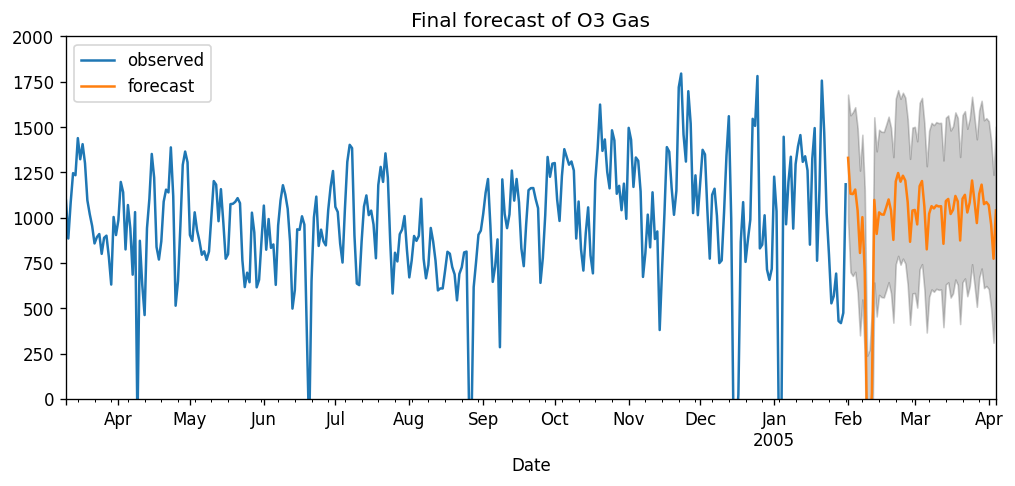

In [470]:
ax = df_O3['O3'].plot(figsize=(10, 4))
pred_O3_final.predicted_mean.plot(ax=ax)
ax.fill_between(pred_O3_final.conf_int().index,
                pred_O3_final.conf_int().iloc[:, 0],
                pred_O3_final.conf_int().iloc[:, 1], color='k', alpha=.2)
ax.set(ylim=(0,2000))
plt.legend(loc=2, labels=['observed', 'forecast'])
plt.title("Final forecast of O3 Gas")
plt.show()

In [471]:
# Form the final sample submission
pred_df = pd.concat([pred_CO_final.predicted_mean, pred_NMHC_final.predicted_mean, pred_NOX_final.predicted_mean, pred_O3_final.predicted_mean])
pred_df = pred_df.reset_index()
pred_df.columns = ['id', 'Value']
pred_df["id"] = pred_df.index
pred_df

id        Value
0      0  1185.455651
1      1  1115.184593
2      2  1164.257368
3      3  1170.167111
4      4  1103.367628
..   ...          ...
247  247  1085.991653
248  248  1068.869825
249  249   961.118408
250  250   773.156945
251  251  1039.941178

[252 rows x 2 columns]

In [472]:
pred_df.to_csv('DevynSubmission5.csv', index=False)

In [473]:
# def rmse(validCount, predCount):
#   return sqrt(mean_squared_error(validCount, predCount))
  
# def evaluate_sarima_model(train, test, arima_order, seasonalOrder):
#     try:
#         # no need to calcuate if order as well as seasonal differencing is 0
#         if (arima_order[1]+seasonalOrder[1])==0:
#           print(f"##### Skipped modelling with: {arima_order}, {seasonalOrder} --> Both d & D are zeroes\n")
#           # return a high value of RMSE so that it sits at the bottom of the list when sorted
#           return 999999999, arima_order, seasonalOrder
          
#         y_hat = test.copy() 
#         model = SARIMAX(train, order=arima_order, seasonal_order=seasonalOrder, exog=df_O3[['RH']].loc['2004-03-10':'2004-10-10'])
#         model_fit = model.fit()
#         predict = model_fit.get_prediction(start=pd.to_datetime('2004-03-10'),
#                                   end=pd.to_datetime('2005-01-31'), exog=testdf_O3[['RH']]).predicted_mean
#         y_hat['model_prediction']=predict
#         error = rmse(test, y_hat.model_prediction)
#         print(f"> Model: {error}, {arima_order}, {seasonalOrder}\n")
#         return error, arima_order, seasonalOrder
#     except Exception as e:
#         # in case of convergence errors, non-invertible errors, etc.
#         print(f"##### Skipped modelling with: {arima_order}, {seasonalOrder}\n")
#         print(e)
#         return 999999999, arima_order, seasonalOrder

# def evaluate_models_parallely(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, m_values):
#     # utilize aall available cores using n_jobs = cpu_count()
#     executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 

#     scor = []
#     try:
#       # call our function in a parallel manner
#       tasks = (delayed(evaluate_sarima_model)(train, test, (p,d,q), (P,D,Q,m)) for m in m_values for Q in Q_values for D in D_values for P in P_values for q in q_values for d in d_values for p in p_values)  
#       results = executor(tasks)

#       scor.append(results)
#     except Exception as e:
#       print('Fatal Error....')
#       print(e)

#     return scor

In [474]:
# # specify the range of values we want ot try for the different hyperprameters
# p_values = np.arange(0, 2)
# d_values = np.arange(1, 2)
# q_values = np.arange(1, 3)
# P_values = np.arange(0, 2)
# D_values = np.arange(1, 2)
# Q_values = np.arange(0, 3)
# m_values = np.arange(7)


# scor=evaluate_models_parallely(df_O3['O3'].loc['2004-03-10':'2004-10-10'], df_O3['O3'].loc['2004-10-11':'2005-01-31'], p_values, d_values, q_values, P_values, D_values, Q_values, m_values)

# scores=[]
# for tup_list in scor:
#     for tup in tup_list:
#         scores.append(tup)

# # sort the results on basis of RMSE scores (ascending)
# scores.sort(key=lambda x: x[0])

# print('\nTop 5 SARIMA params with minimum RMSEs:\n')
# for x in scores[:5]:
#   print(f'RMSE={x[0]}  order={x[1]}  seasonal_order={x[2]}\n')

# print("DONE!")

## Here I tried to do hyperparameter tuning but it took way too long so I did not manage to do it.